In [327]:
import logging
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import random
from scipy.stats import gaussian_kde
import seaborn as sns
import sympy as sp

import importlib
import toylosses
importlib.reload(toylosses)
import toynn
importlib.reload(toynn)
import toyvis
importlib.reload(toyvis)


import torch
import torch.nn as tnn
from torch.nn import functional as F
sns.set()

random.seed(0)
np.random.seed(1)
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [ ]:
# Mixture of FA / PPCA
# Models parameters

W = np.array([
    [[2], [3]],  # W1
    [[-1], [1]],  # W2
    [[2], [1]]  # W3
])

mu = np.array([
    [2, 3],  # mu1
    [-1, 1],  # mu2
    [2, 1]  # mu3
])

probabilities = np.array([0.1, 0.6, 0.3])
# Sample latent variable, noise -> generate data
n = 1000
z = np.random.normal(size=(n, 1))
s = 0.1
eps = np.random.normal(loc=0, scale=s**2, size=(n, 2))  # PPCA because it is isotropic

# Generative model
c = np.random.choice([0, 1, 2], n, p=probabilities)

mask = np.zeros((n, 3))
for i in range(n): 
    mask[i] = c[i] == range(3)
ws = np.einsum('nm, mij->nij', mask, W)
mus = np.einsum('nm, mi->ni', mask, mu)
x = np.einsum('nij,nj->ni', ws, z) 
x = x + mus + eps

# Plot data
plt.scatter(x[:, 0], x[:, 1])
plt.axis('equal')

## Generating synthetic data from 2D model: x = W^T z + mu + eps

In [ ]:
# Models parameters
w1 = 2
w2 = 3
W = np.array([[w1], [w2]])
mu1 = -1
mu2 = 1
mu = np.array([mu1, mu2])
print(mu.shape)

# Sample latent variable, noise -> generate data
n = 100
z = np.random.normal(size=(n, 1))
print(z.shape)
s = 0.1
eps = np.random.normal(loc=0, scale=s**2, size=(n, 2))  # PPCA because it is isotropic
print(eps.shape)

# Generative model
x = np.einsum('ij,nj->ni', W, z) + mu + eps
x = np.maximum(x, 0)  # ReLu 
print(x.shape)
# Plot data
plt.scatter(x[:, 0], x[:, 1])
plt.axis('equal')

# Adding a second layer
v1 = -4
v2 = 7
V = np.array([[v1], [v2]])
m1 = 3
m2 = 5
m = np.array([m1, m2])
print(mu.shape)

# Generative model
h = np.einsum('ij,nj->ni', W, z) + mu
h = np.maximum(h, 0)  # ReLu 
eps = np.random.normal(loc=0, scale=s**2, size=(n, 2))  # PPCA because it is isotropic
x = np.einsum('ij,nj->ni', V, h) + m + eps
x = np.maximum(x, 0)  # ReLu 
print(x.shape)
# Plot data
plt.figure()
plt.scatter(x[:, 0], x[:, 1])
plt.axis('equal')

# Generate synthetic data from a VAE's decoder

Examples of parameters for the decoder

In [ ]:
w_true = {}
b_true = {}

w_true[0] = [[1.], [1.]]
b_true[0] = [0., -1.]

# For the reconstruction
w_true[1] = [[2., 1.], [-1., 2.]]
b_true[1] = [0., 0.]

# For the scale
w_true[2] = [[1., -1.], [0., 1.]]
b_true[2] = [0., 0.]


## Parameters 1

w_true = {}
b_true = {}

# For the reconstruction
w_true[0] = [[4.], [4.]]
b_true[0] = [0., -0.]

# For the scale
w_true[1] = [[-0.], [-0.]]
b_true[1] = [0., -0.]


## Parameters 2
DEVICE = 'cuda'

data_dim = 1
latent_dim = 1
n_layers = 1
nonlinearity = False
n_samples = 10000
with_biasx = False
with_logvarx = False

w_true = {}
b_true = {}

# For the reconstruction
w_true[0] = [[2.]]
if with_biasx:
    b_true[0] = [[0.]]

if with_logvarx:
    # For the scale
    w_true[1] = [[0.]]
    b_true[1] = [[0.]]


layers.0.weight tensor([[2.]], device='cuda:0') 

Covariance matrix from decoder:
4.925015160331548
Covariance matrix from synthetic:
5.016637077188237


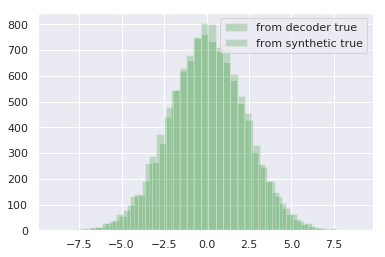

In [328]:
DEVICE = 'cuda'

data_dim = 1
latent_dim = 1
n_layers = 1
nonlinearity = False
n_samples = 10000
with_biasx = False
with_logvarx = False

w_true = {}
b_true = {}

# For the reconstruction
w_true[0] = [[2.]]
if with_biasx:
    b_true[0] = [[0.]]

if with_logvarx:
    # For the scale
    w_true[1] = [[0.]]
    b_true[1] = [[0.]]

decoder_true = toynn.make_decoder_true(
    w_true, b_true, latent_dim, data_dim, n_layers,
    nonlinearity, with_biasx, with_logvarx)

for name, param in decoder_true.named_parameters():
    print(name, param.data, '\n')
    

w_true = 2
color_true = 'green'
def generate_synthetic_1d(w=w_true, n=10):
    z = np.random.normal(loc=0, scale=1, size=(n, 1))
    eps = np.random.normal(loc=0, scale=1, size=(n, 1))

    x = w * z + eps
    return z, x

generated_x = toynn.generate_from_decoder(decoder_true, n_samples)
_, synthetic_x = generate_synthetic_1d(w=w_true, n=n_samples)



fig, ax = plt.subplots()
ax = toyvis.plot_data(generated_x, color='green', label='from decoder true', ax=ax)
ax = toyvis.plot_data(synthetic_x, color='green', label='from synthetic true', ax=ax)
ax.legend(loc='upper right')

print('Covariance matrix from decoder:')
cov = np.cov(generated_x.T)
print(cov)

print('Covariance matrix from synthetic:')
cov = np.cov(synthetic_x.T)
print(cov)


# Build a VAE to learn the decoder's distribution

### Train/Test set

In [216]:
FRAC_TEST = 0.2
n_train = int((1 - FRAC_TEST) * n_samples)
BATCH_SIZE = 64
CUDA = torch.cuda.is_available()
KWARGS = {'num_workers': 1, 'pin_memory': True} if CUDA else {}

train = torch.Tensor(generated_x[:n_train, :])
test = torch.Tensor(generated_x[n_train: , :])

logging.info('-- Train tensor: (%d, %d)' % train.shape)
train_dataset = torch.utils.data.TensorDataset(train)
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True, **KWARGS)

logging.info('-- Test tensor: (%d, %d)' % test.shape)
test_dataset = torch.utils.data.TensorDataset(test)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=BATCH_SIZE, shuffle=True, **KWARGS)

From the unregularized VAE:

\begin{align*}
    L_{ELBO} 
  = L_{UVAE} - KL_{prior}(\phi) 
  = \mathbb{E}_{p_{data}(x)}\left[ \mathbb{E}_{q_\phi(z|x)} \left[\log p_\theta(x|z)\right] - KL\left(q_\phi(z|x) || p(z)\right) \right] 
\end{align*}

Where the $\mathbb{E}$ is taken over the batch of data.

In [329]:
b_data = torch.Tensor(np.array([[0., 0., 0.], [0., 0., 0.]])).to(DEVICE)
b_recon = torch.Tensor(np.array([[2., 2., 2.], [3., 3., 3.]])).to(DEVICE)

b_logvarx = torch.Tensor(np.array([[np.log(1.)], [np.log(2.)]])).to(DEVICE)
print('1111', toylosses.reconstruction_loss(b_data, b_recon, b_logvarx))

#expected_ssd = tensor([12., 27.])
#expected_ssd_term = tensor([-6.0000, -6.7500])

b_data = torch.Tensor(np.array([[0., 0., 0.], [0., 0., 0.]])).to(DEVICE)
b_recon = torch.Tensor(np.array([[2., 2., 2.], [3., 3., 3.]])).to(DEVICE)

b_logvarx = torch.Tensor(
    np.array(
        [[np.log(1.), np.log(1.), np.log(1.)], 
         [np.log(2.), np.log(2.), np.log(2.)]])).to(DEVICE)
print('2222', toylosses.reconstruction_loss(b_data, b_recon, b_logvarx))
#1111 tensor(9.6517, device='cuda:0')
#2222 tensor(9.6517, device='cuda:0')

1111 tensor(9.6517, device='cuda:0')
2222 tensor(9.6517, device='cuda:0')


In [307]:
DEBUG = False
PRINT_INTERVAL = 16

def toytrain_vae(epoch, train_loader, modules, optimizers):
    for module in modules.values():
        module.train()
    total_loss_reconstruction = 0
    total_loss_regularization = 0
    total_loss = 0
    
    n_data = len(train_loader.dataset)
    n_batches = len(train_loader)
    
    for batch_idx, batch_data in enumerate(train_loader):
        if DEBUG:
            if batch_idx > 3:
                continue
        
        batch_data = batch_data[0].to(DEVICE)
        n_batch_data = len(batch_data)
        
        for optimizer in optimizers.values():
            optimizer.zero_grad()
            
        encoder = modules['encoder']
        decoder = modules['decoder']
        
        mu, logvar = encoder(batch_data)
        
        z = toynn.sample_from_q(mu, logvar).to(DEVICE)
        batch_recon, batch_logvarx = decoder(z)
        
        z_from_prior = toynn.sample_from_prior(
                latent_dim, n_samples=n_batch_data).to(DEVICE)
        batch_from_prior, scale_b_from_prior = decoder(
                z_from_prior)
        
        loss_reconstruction = toylosses.reconstruction_loss(batch_data, batch_recon, batch_logvarx)
        loss_reconstruction.backward(retain_graph=True)
        loss_regularization = toylosses.regularization_loss(mu, logvar)  # kld
        loss_regularization.backward()
           
        optimizers['encoder'].step()
        optimizers['decoder'].step()            
        
        loss = loss_reconstruction + loss_regularization
        
        if batch_idx % PRINT_INTERVAL == 0:
            logloss = loss / n_batch_data
            logloss_reconstruction = loss_reconstruction / n_batch_data
            logloss_regularization = loss_regularization / n_batch_data
            
            string_base = ('Train Epoch: {} [{}/{} ({:.0f}%)]\tTotal Loss: {:.6f}'
                       + '\nReconstruction: {:.6f}, Regularization: {:.6f}')
            print(
                string_base.format(
                    epoch, batch_idx * n_batch_data, n_data,
                    100. * batch_idx / n_batches,
                    logloss, logloss_reconstruction, logloss_regularization))
            
        total_loss_reconstruction += loss_reconstruction.item()
        total_loss_regularization += loss_regularization.item()
        total_loss += loss.item()

    
    average_loss_reconstruction = total_loss_reconstruction / n_data
    average_loss_regularization = total_loss_regularization / n_data
    average_loss = total_loss / n_data
    
    print('====> Epoch: {} Average loss: {:.4f}'.format(
            epoch, average_loss))
    train_losses = {}
    train_losses['reconstruction'] = average_loss_reconstruction
    train_losses['regularization'] = average_loss_regularization
    train_losses['total'] = average_loss
    return train_losses

by modifying the VAE criterion and integrating GANs, we can provide a NN implementation of the variational EM.

- Send a batch through the VAE
- Compute the VAE loss: the reconstruction error and the regularization
- back propagate through the entire VAE
- update only the encoder: this will update it wrt to the -KL( || posterior), this is the E step of the variational EM.
- Generate N data Z from the prior
- Propagate through the decoder
- Use a GAN to distinguish the distribution in $\tilde x$ from N data from the true distribution: generate ONE sample Z, and ask the discriminator.
- back propagate this through the decoder
- update the decoder w.r.t. only this.

In [306]:
def toytrain_vem(epoch, train_loader, modules, optimizers):
    for module in modules.values():
        module.train()
    total_loss_reconstruction = 0
    total_loss_regularization = 0
    total_loss_discriminator = 0
    total_loss_generator = 0
    total_loss = 0
    
    n_data = len(train_loader.dataset)
    n_batches = len(train_loader)
    
    for batch_idx, batch_data in enumerate(train_loader):
        if DEBUG:
            if batch_idx > 3:
                continue
        
        batch_data = batch_data[0].to(DEVICE)
        n_batch_data = len(batch_data)
        
        for optimizer in optimizers.values():
            optimizer.zero_grad()
            
        encoder = modules['encoder']
        decoder = modules['decoder']
        
        mu, logvar = encoder(batch_data)
        
        z = toynn.sample_from_q(
                mu, logvar).to(DEVICE)
        batch_recon, batch_logvarx = decoder(z)
        
        z_from_prior = toynn.sample_from_prior(
                latent_dim, n_samples=n_batch_data).to(DEVICE)
        batch_from_prior, batch_logvarx_from_prior = decoder(
                z_from_prior)
        
        loss_reconstruction = toylosses.reconstruction_loss(batch_data, batch_recon, batch_logvarx)
        loss_reconstruction.backward(retain_graph=True)
        loss_regularization = toylosses.regularization_loss(mu, logvar)  # kld
        loss_regularization.backward()
        
        ## - ENCODER STEP -
        optimizers['encoder'].step()
        ## - - - - - - - - -
        
        n_from_prior = int(np.random.uniform(
            low=n_batch_data - n_batch_data / 4, 
            high=n_batch_data + n_batch_data / 4))
        z_from_prior = toynn.sample_from_prior(latent_dim, n_samples=n_from_prior)
        batch_recon_from_prior, batch_logvarx_from_prior = decoder(z_from_prior)
            
        discriminator = modules['discriminator']
        
        real_labels = torch.full((n_batch_data, 1), 1, device=DEVICE)
        fake_labels = torch.full((n_batch_data, 1), 0, device=DEVICE)
        
        # -- Update Discriminator
        labels_data = discriminator(batch_data)
        labels_from_prior = discriminator(batch_from_prior)  #.detach())

        loss_dis_data = F.binary_cross_entropy(
                    labels_data,
                    real_labels)
        loss_dis_from_prior = F.binary_cross_entropy(
                    labels_from_prior,
                    fake_labels)

        loss_discriminator = (
                loss_dis_data + loss_dis_from_prior)

        # Fill gradients on discriminator only
        loss_discriminator.backward(retain_graph=True)
        
        ## - DISCRIMINATOR STEP -
        # Before filing with gradient of loss_generator
        optimizers['discriminator'].step()
        ## - - - - - - - - -

        # -- Update Generator/Decoder
        loss_generator = F.binary_cross_entropy(
                labels_from_prior,
                real_labels)

        # Fill gradients on generator only
        # FREE THE DECODER:
        optimizers['decoder'].zero_grad()
        # Only back propagate the loss of the generator through the deocder
        loss_generator.backward()       
            
        ## - DECODER STEP -
        optimizers['decoder'].step()
        ## - - - - - - - - -

        loss = loss_reconstruction + loss_regularization
        loss += loss_discriminator + loss_generator     
        
        if batch_idx % PRINT_INTERVAL == 0:
            average_batch_loss = loss / n_batch_data
            average_batch_loss_reconstruction = loss_reconstruction / n_batch_data
            average_batch_loss_regularization = loss_regularization / n_batch_data
            average_batch_loss_discriminator = loss_discriminator / n_batch_data
            average_batch_loss_generator = loss_generator / n_batch_data
            
            dx = labels_data.mean()
            dgz = labels_from_prior.mean()
            
            string_base = ('Train Epoch: {} [{}/{} ({:.0f}%)]\tTotal Loss: {:.6f}'
                       + '\nReconstruction: {:.6f}, Regularization: {:.6f}')
            string_base += (
                ', Discriminator: {:.6f}; Generator: {:.6f},'
                '\nD(x): {:.3f}, D(G(z)): {:.3f}')
            print(
                string_base.format(
                    epoch, batch_idx * n_batch_data, n_data,
                    100. * batch_idx / n_batches,
                    average_batch_loss,
                    average_batch_loss_reconstruction, 
                    average_batch_loss_regularization,
                    average_batch_loss_discriminator,
                    average_batch_loss_generator,
                    dx, dgz))
            
        total_loss_reconstruction += loss_reconstruction.item()
        total_loss_regularization += loss_regularization.item()
        total_loss_discriminator += loss_discriminator.item()
        total_loss_generator += loss_generator.item()
        
        total_loss += loss.item()
    
    average_loss_reconstruction = total_loss_reconstruction / n_data
    average_loss_regularization = total_loss_regularization / n_data
    average_loss = total_loss / n_data
    
    print('====> Epoch: {} Average loss: {:.4f}'.format(
            epoch, average_loss))
    train_losses = {}
    train_losses['reconstruction'] = average_loss_reconstruction
    train_losses['regularization'] = average_loss_regularization
    train_losses['total'] = average_loss
    return train_losses

## Train VAE

In [308]:
N_EPOCHS = 200
LR = 1e-4  # TODO: increase LR
BETA1 = 0.5
BETA2 = 0.999

PRINT_INTERVAL = 16
N_FROM_PRIOR = 1000


random.seed(0)
np.random.seed(1)
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

vae = toynn.VAE(
    latent_dim=latent_dim, data_dim=data_dim, 
    n_layers=n_layers, nonlinearity=nonlinearity,
    with_biasx=False,
    with_logvarx=False,
    with_biasz=False,
    with_logvarz=False)
vae.to(DEVICE)

modules = {}
modules['encoder'] = vae.encoder
modules['decoder'] = vae.decoder

print('\n-- Values of parameters before learning')
decoder = modules['decoder']
for name, param in decoder.named_parameters():
    print(name, param.data, '\n')

optimizers = {}
optimizers['encoder'] = torch.optim.Adam(
    modules['encoder'].parameters(), lr=LR, betas=(BETA1, BETA2))
optimizers['decoder'] = torch.optim.Adam(
    modules['decoder'].parameters(), lr=LR, betas=(BETA1, BETA2))

def init_xavier_normal(m):
    if type(m) == tnn.Linear:
        tnn.init.xavier_normal_(m.weight)
    else:
        print('Error of layer type.', type(m))
        
for module in modules.values():
    module.apply(init_xavier_normal)


train_losses_all_epochs = []
test_losses_all_epochs = []

for epoch in range(N_EPOCHS):
    train_losses = toytrain_vae(
        epoch, train_loader, modules, optimizers)
    
    train_losses_all_epochs.append(train_losses)


-- Values of parameters before learning
layers.0.weight tensor([[-0.7359]], device='cuda:0') 

Error of layer type. <class 'toynn.Encoder'>
Error of layer type. <class 'torch.nn.modules.activation.ReLU'>
Error of layer type. <class 'torch.nn.modules.container.ModuleList'>
Error of layer type. <class 'toynn.Decoder'>
Train Epoch: 0 [0/8000 (0%)]	Total Loss: 0.088081
Reconstruction: 0.030505, Regularization: 0.057577
Train Epoch: 0 [1024/8000 (13%)]	Total Loss: 0.093865
Reconstruction: 0.030928, Regularization: 0.062937
Train Epoch: 0 [2048/8000 (26%)]	Total Loss: 0.124084
Reconstruction: 0.037811, Regularization: 0.086272
Train Epoch: 0 [3072/8000 (38%)]	Total Loss: 0.145185
Reconstruction: 0.041680, Regularization: 0.103505
Train Epoch: 0 [4096/8000 (51%)]	Total Loss: 0.093742
Reconstruction: 0.031520, Regularization: 0.062222
Train Epoch: 0 [5120/8000 (64%)]	Total Loss: 0.100848
Reconstruction: 0.032520, Regularization: 0.068328
Train Epoch: 0 [6144/8000 (77%)]	Total Loss: 0.077221
R

Train Epoch: 9 [3072/8000 (38%)]	Total Loss: 0.074821
Reconstruction: 0.026554, Regularization: 0.048267
Train Epoch: 9 [4096/8000 (51%)]	Total Loss: 0.080178
Reconstruction: 0.026933, Regularization: 0.053245
Train Epoch: 9 [5120/8000 (64%)]	Total Loss: 0.100750
Reconstruction: 0.029573, Regularization: 0.071178
Train Epoch: 9 [6144/8000 (77%)]	Total Loss: 0.079217
Reconstruction: 0.027061, Regularization: 0.052156
Train Epoch: 9 [7168/8000 (90%)]	Total Loss: 0.100073
Reconstruction: 0.030267, Regularization: 0.069807
====> Epoch: 9 Average loss: 0.0910
Train Epoch: 10 [0/8000 (0%)]	Total Loss: 0.081390
Reconstruction: 0.028136, Regularization: 0.053254
Train Epoch: 10 [1024/8000 (13%)]	Total Loss: 0.077678
Reconstruction: 0.026771, Regularization: 0.050907
Train Epoch: 10 [2048/8000 (26%)]	Total Loss: 0.061873
Reconstruction: 0.023421, Regularization: 0.038452
Train Epoch: 10 [3072/8000 (38%)]	Total Loss: 0.083352
Reconstruction: 0.026726, Regularization: 0.056626
Train Epoch: 10 [40

Train Epoch: 18 [6144/8000 (77%)]	Total Loss: 0.076106
Reconstruction: 0.027591, Regularization: 0.048515
Train Epoch: 18 [7168/8000 (90%)]	Total Loss: 0.061618
Reconstruction: 0.023265, Regularization: 0.038353
====> Epoch: 18 Average loss: 0.0785
Train Epoch: 19 [0/8000 (0%)]	Total Loss: 0.079067
Reconstruction: 0.027272, Regularization: 0.051795
Train Epoch: 19 [1024/8000 (13%)]	Total Loss: 0.082122
Reconstruction: 0.027528, Regularization: 0.054594
Train Epoch: 19 [2048/8000 (26%)]	Total Loss: 0.086734
Reconstruction: 0.027033, Regularization: 0.059701
Train Epoch: 19 [3072/8000 (38%)]	Total Loss: 0.076808
Reconstruction: 0.026808, Regularization: 0.050000
Train Epoch: 19 [4096/8000 (51%)]	Total Loss: 0.084286
Reconstruction: 0.026184, Regularization: 0.058103
Train Epoch: 19 [5120/8000 (64%)]	Total Loss: 0.091728
Reconstruction: 0.028993, Regularization: 0.062736
Train Epoch: 19 [6144/8000 (77%)]	Total Loss: 0.057395
Reconstruction: 0.022774, Regularization: 0.034621
Train Epoch: 

Train Epoch: 28 [1024/8000 (13%)]	Total Loss: 0.063582
Reconstruction: 0.023887, Regularization: 0.039695
Train Epoch: 28 [2048/8000 (26%)]	Total Loss: 0.061159
Reconstruction: 0.023228, Regularization: 0.037931
Train Epoch: 28 [3072/8000 (38%)]	Total Loss: 0.081036
Reconstruction: 0.028129, Regularization: 0.052907
Train Epoch: 28 [4096/8000 (51%)]	Total Loss: 0.057570
Reconstruction: 0.023019, Regularization: 0.034551
Train Epoch: 28 [5120/8000 (64%)]	Total Loss: 0.067263
Reconstruction: 0.025793, Regularization: 0.041470
Train Epoch: 28 [6144/8000 (77%)]	Total Loss: 0.062636
Reconstruction: 0.023716, Regularization: 0.038920
Train Epoch: 28 [7168/8000 (90%)]	Total Loss: 0.062185
Reconstruction: 0.023970, Regularization: 0.038215
====> Epoch: 28 Average loss: 0.0676
Train Epoch: 29 [0/8000 (0%)]	Total Loss: 0.068720
Reconstruction: 0.025048, Regularization: 0.043672
Train Epoch: 29 [1024/8000 (13%)]	Total Loss: 0.056107
Reconstruction: 0.025265, Regularization: 0.030842
Train Epoch: 

Train Epoch: 37 [5120/8000 (64%)]	Total Loss: 0.054625
Reconstruction: 0.026016, Regularization: 0.028609
Train Epoch: 37 [6144/8000 (77%)]	Total Loss: 0.059106
Reconstruction: 0.024082, Regularization: 0.035024
Train Epoch: 37 [7168/8000 (90%)]	Total Loss: 0.050744
Reconstruction: 0.022656, Regularization: 0.028089
====> Epoch: 37 Average loss: 0.0596
Train Epoch: 38 [0/8000 (0%)]	Total Loss: 0.060270
Reconstruction: 0.023674, Regularization: 0.036597
Train Epoch: 38 [1024/8000 (13%)]	Total Loss: 0.070063
Reconstruction: 0.028913, Regularization: 0.041150
Train Epoch: 38 [2048/8000 (26%)]	Total Loss: 0.067194
Reconstruction: 0.026215, Regularization: 0.040979
Train Epoch: 38 [3072/8000 (38%)]	Total Loss: 0.053648
Reconstruction: 0.022753, Regularization: 0.030895
Train Epoch: 38 [4096/8000 (51%)]	Total Loss: 0.054889
Reconstruction: 0.024135, Regularization: 0.030754
Train Epoch: 38 [5120/8000 (64%)]	Total Loss: 0.063656
Reconstruction: 0.026378, Regularization: 0.037278
Train Epoch: 

====> Epoch: 46 Average loss: 0.0533
Train Epoch: 47 [0/8000 (0%)]	Total Loss: 0.057373
Reconstruction: 0.027825, Regularization: 0.029549
Train Epoch: 47 [1024/8000 (13%)]	Total Loss: 0.055442
Reconstruction: 0.027417, Regularization: 0.028025
Train Epoch: 47 [2048/8000 (26%)]	Total Loss: 0.045150
Reconstruction: 0.024960, Regularization: 0.020190
Train Epoch: 47 [3072/8000 (38%)]	Total Loss: 0.059065
Reconstruction: 0.027760, Regularization: 0.031306
Train Epoch: 47 [4096/8000 (51%)]	Total Loss: 0.051714
Reconstruction: 0.025191, Regularization: 0.026523
Train Epoch: 47 [5120/8000 (64%)]	Total Loss: 0.049570
Reconstruction: 0.025333, Regularization: 0.024237
Train Epoch: 47 [6144/8000 (77%)]	Total Loss: 0.045914
Reconstruction: 0.022699, Regularization: 0.023215
Train Epoch: 47 [7168/8000 (90%)]	Total Loss: 0.047220
Reconstruction: 0.023794, Regularization: 0.023426
====> Epoch: 47 Average loss: 0.0527
Train Epoch: 48 [0/8000 (0%)]	Total Loss: 0.055015
Reconstruction: 0.025447, Regul

Train Epoch: 56 [3072/8000 (38%)]	Total Loss: 0.048338
Reconstruction: 0.026624, Regularization: 0.021714
Train Epoch: 56 [4096/8000 (51%)]	Total Loss: 0.047213
Reconstruction: 0.026179, Regularization: 0.021034
Train Epoch: 56 [5120/8000 (64%)]	Total Loss: 0.055534
Reconstruction: 0.028948, Regularization: 0.026587
Train Epoch: 56 [6144/8000 (77%)]	Total Loss: 0.044216
Reconstruction: 0.025438, Regularization: 0.018778
Train Epoch: 56 [7168/8000 (90%)]	Total Loss: 0.042184
Reconstruction: 0.024405, Regularization: 0.017780
====> Epoch: 56 Average loss: 0.0481
Train Epoch: 57 [0/8000 (0%)]	Total Loss: 0.050819
Reconstruction: 0.029861, Regularization: 0.020958
Train Epoch: 57 [1024/8000 (13%)]	Total Loss: 0.048841
Reconstruction: 0.023377, Regularization: 0.025464
Train Epoch: 57 [2048/8000 (26%)]	Total Loss: 0.048749
Reconstruction: 0.027429, Regularization: 0.021320
Train Epoch: 57 [3072/8000 (38%)]	Total Loss: 0.062604
Reconstruction: 0.029159, Regularization: 0.033445
Train Epoch: 

Train Epoch: 65 [7168/8000 (90%)]	Total Loss: 0.038985
Reconstruction: 0.027129, Regularization: 0.011856
====> Epoch: 65 Average loss: 0.0448
Train Epoch: 66 [0/8000 (0%)]	Total Loss: 0.037812
Reconstruction: 0.023443, Regularization: 0.014369
Train Epoch: 66 [1024/8000 (13%)]	Total Loss: 0.043406
Reconstruction: 0.026424, Regularization: 0.016982
Train Epoch: 66 [2048/8000 (26%)]	Total Loss: 0.049122
Reconstruction: 0.031412, Regularization: 0.017710
Train Epoch: 66 [3072/8000 (38%)]	Total Loss: 0.050106
Reconstruction: 0.028227, Regularization: 0.021880
Train Epoch: 66 [4096/8000 (51%)]	Total Loss: 0.047739
Reconstruction: 0.028544, Regularization: 0.019196
Train Epoch: 66 [5120/8000 (64%)]	Total Loss: 0.038311
Reconstruction: 0.026028, Regularization: 0.012282
Train Epoch: 66 [6144/8000 (77%)]	Total Loss: 0.039622
Reconstruction: 0.025871, Regularization: 0.013751
Train Epoch: 66 [7168/8000 (90%)]	Total Loss: 0.043796
Reconstruction: 0.026749, Regularization: 0.017047
====> Epoch: 

Train Epoch: 75 [3072/8000 (38%)]	Total Loss: 0.042521
Reconstruction: 0.030286, Regularization: 0.012235
Train Epoch: 75 [4096/8000 (51%)]	Total Loss: 0.047204
Reconstruction: 0.032038, Regularization: 0.015166
Train Epoch: 75 [5120/8000 (64%)]	Total Loss: 0.041959
Reconstruction: 0.026960, Regularization: 0.014999
Train Epoch: 75 [6144/8000 (77%)]	Total Loss: 0.060044
Reconstruction: 0.039562, Regularization: 0.020482
Train Epoch: 75 [7168/8000 (90%)]	Total Loss: 0.039161
Reconstruction: 0.025795, Regularization: 0.013365
====> Epoch: 75 Average loss: 0.0429
Train Epoch: 76 [0/8000 (0%)]	Total Loss: 0.040343
Reconstruction: 0.027833, Regularization: 0.012510
Train Epoch: 76 [1024/8000 (13%)]	Total Loss: 0.047348
Reconstruction: 0.030785, Regularization: 0.016563
Train Epoch: 76 [2048/8000 (26%)]	Total Loss: 0.038438
Reconstruction: 0.027237, Regularization: 0.011201
Train Epoch: 76 [3072/8000 (38%)]	Total Loss: 0.043319
Reconstruction: 0.028534, Regularization: 0.014784
Train Epoch: 

Train Epoch: 84 [7168/8000 (90%)]	Total Loss: 0.043194
Reconstruction: 0.032973, Regularization: 0.010222
====> Epoch: 84 Average loss: 0.0420
Train Epoch: 85 [0/8000 (0%)]	Total Loss: 0.038698
Reconstruction: 0.028407, Regularization: 0.010291
Train Epoch: 85 [1024/8000 (13%)]	Total Loss: 0.048737
Reconstruction: 0.035845, Regularization: 0.012891
Train Epoch: 85 [2048/8000 (26%)]	Total Loss: 0.038712
Reconstruction: 0.027931, Regularization: 0.010781
Train Epoch: 85 [3072/8000 (38%)]	Total Loss: 0.040001
Reconstruction: 0.029537, Regularization: 0.010464
Train Epoch: 85 [4096/8000 (51%)]	Total Loss: 0.044660
Reconstruction: 0.031610, Regularization: 0.013050
Train Epoch: 85 [5120/8000 (64%)]	Total Loss: 0.038604
Reconstruction: 0.028996, Regularization: 0.009608
Train Epoch: 85 [6144/8000 (77%)]	Total Loss: 0.042741
Reconstruction: 0.029843, Regularization: 0.012899
Train Epoch: 85 [7168/8000 (90%)]	Total Loss: 0.043077
Reconstruction: 0.031869, Regularization: 0.011209
====> Epoch: 

Train Epoch: 94 [2048/8000 (26%)]	Total Loss: 0.048475
Reconstruction: 0.037410, Regularization: 0.011065
Train Epoch: 94 [3072/8000 (38%)]	Total Loss: 0.036627
Reconstruction: 0.028852, Regularization: 0.007775
Train Epoch: 94 [4096/8000 (51%)]	Total Loss: 0.044308
Reconstruction: 0.034788, Regularization: 0.009520
Train Epoch: 94 [5120/8000 (64%)]	Total Loss: 0.046273
Reconstruction: 0.032563, Regularization: 0.013710
Train Epoch: 94 [6144/8000 (77%)]	Total Loss: 0.037475
Reconstruction: 0.028851, Regularization: 0.008624
Train Epoch: 94 [7168/8000 (90%)]	Total Loss: 0.038509
Reconstruction: 0.028316, Regularization: 0.010193
====> Epoch: 94 Average loss: 0.0410
Train Epoch: 95 [0/8000 (0%)]	Total Loss: 0.039944
Reconstruction: 0.031577, Regularization: 0.008367
Train Epoch: 95 [1024/8000 (13%)]	Total Loss: 0.045133
Reconstruction: 0.033373, Regularization: 0.011761
Train Epoch: 95 [2048/8000 (26%)]	Total Loss: 0.038593
Reconstruction: 0.030324, Regularization: 0.008269
Train Epoch: 

Train Epoch: 103 [6144/8000 (77%)]	Total Loss: 0.040473
Reconstruction: 0.030199, Regularization: 0.010273
Train Epoch: 103 [7168/8000 (90%)]	Total Loss: 0.037540
Reconstruction: 0.028688, Regularization: 0.008852
====> Epoch: 103 Average loss: 0.0414
Train Epoch: 104 [0/8000 (0%)]	Total Loss: 0.038322
Reconstruction: 0.029560, Regularization: 0.008763
Train Epoch: 104 [1024/8000 (13%)]	Total Loss: 0.043086
Reconstruction: 0.032830, Regularization: 0.010257
Train Epoch: 104 [2048/8000 (26%)]	Total Loss: 0.043353
Reconstruction: 0.034110, Regularization: 0.009244
Train Epoch: 104 [3072/8000 (38%)]	Total Loss: 0.048023
Reconstruction: 0.037572, Regularization: 0.010451
Train Epoch: 104 [4096/8000 (51%)]	Total Loss: 0.037167
Reconstruction: 0.028713, Regularization: 0.008455
Train Epoch: 104 [5120/8000 (64%)]	Total Loss: 0.030788
Reconstruction: 0.023940, Regularization: 0.006849
Train Epoch: 104 [6144/8000 (77%)]	Total Loss: 0.039468
Reconstruction: 0.030006, Regularization: 0.009462
Tra

====> Epoch: 112 Average loss: 0.0408
Train Epoch: 113 [0/8000 (0%)]	Total Loss: 0.039638
Reconstruction: 0.030018, Regularization: 0.009620
Train Epoch: 113 [1024/8000 (13%)]	Total Loss: 0.035976
Reconstruction: 0.028467, Regularization: 0.007509
Train Epoch: 113 [2048/8000 (26%)]	Total Loss: 0.037668
Reconstruction: 0.027989, Regularization: 0.009679
Train Epoch: 113 [3072/8000 (38%)]	Total Loss: 0.036466
Reconstruction: 0.029699, Regularization: 0.006767
Train Epoch: 113 [4096/8000 (51%)]	Total Loss: 0.041307
Reconstruction: 0.030597, Regularization: 0.010710
Train Epoch: 113 [5120/8000 (64%)]	Total Loss: 0.037849
Reconstruction: 0.030916, Regularization: 0.006932
Train Epoch: 113 [6144/8000 (77%)]	Total Loss: 0.042680
Reconstruction: 0.031877, Regularization: 0.010803
Train Epoch: 113 [7168/8000 (90%)]	Total Loss: 0.040821
Reconstruction: 0.032273, Regularization: 0.008548
====> Epoch: 113 Average loss: 0.0411
Train Epoch: 114 [0/8000 (0%)]	Total Loss: 0.036460
Reconstruction: 0.02

Train Epoch: 122 [3072/8000 (38%)]	Total Loss: 0.043469
Reconstruction: 0.035201, Regularization: 0.008268
Train Epoch: 122 [4096/8000 (51%)]	Total Loss: 0.038519
Reconstruction: 0.029688, Regularization: 0.008831
Train Epoch: 122 [5120/8000 (64%)]	Total Loss: 0.047689
Reconstruction: 0.037280, Regularization: 0.010409
Train Epoch: 122 [6144/8000 (77%)]	Total Loss: 0.044957
Reconstruction: 0.035002, Regularization: 0.009955
Train Epoch: 122 [7168/8000 (90%)]	Total Loss: 0.054967
Reconstruction: 0.041564, Regularization: 0.013403
====> Epoch: 122 Average loss: 0.0417
Train Epoch: 123 [0/8000 (0%)]	Total Loss: 0.044040
Reconstruction: 0.032426, Regularization: 0.011613
Train Epoch: 123 [1024/8000 (13%)]	Total Loss: 0.040276
Reconstruction: 0.032539, Regularization: 0.007737
Train Epoch: 123 [2048/8000 (26%)]	Total Loss: 0.036354
Reconstruction: 0.027064, Regularization: 0.009290
Train Epoch: 123 [3072/8000 (38%)]	Total Loss: 0.043139
Reconstruction: 0.033018, Regularization: 0.010121
Tra

Train Epoch: 131 [5120/8000 (64%)]	Total Loss: 0.036840
Reconstruction: 0.027771, Regularization: 0.009069
Train Epoch: 131 [6144/8000 (77%)]	Total Loss: 0.037640
Reconstruction: 0.028161, Regularization: 0.009479
Train Epoch: 131 [7168/8000 (90%)]	Total Loss: 0.041717
Reconstruction: 0.029969, Regularization: 0.011748
====> Epoch: 131 Average loss: 0.0414
Train Epoch: 132 [0/8000 (0%)]	Total Loss: 0.041758
Reconstruction: 0.032366, Regularization: 0.009392
Train Epoch: 132 [1024/8000 (13%)]	Total Loss: 0.043180
Reconstruction: 0.031907, Regularization: 0.011273
Train Epoch: 132 [2048/8000 (26%)]	Total Loss: 0.038178
Reconstruction: 0.029207, Regularization: 0.008971
Train Epoch: 132 [3072/8000 (38%)]	Total Loss: 0.044565
Reconstruction: 0.035019, Regularization: 0.009546
Train Epoch: 132 [4096/8000 (51%)]	Total Loss: 0.031191
Reconstruction: 0.026928, Regularization: 0.004263
Train Epoch: 132 [5120/8000 (64%)]	Total Loss: 0.042504
Reconstruction: 0.032269, Regularization: 0.010235
Tra

Train Epoch: 140 [7168/8000 (90%)]	Total Loss: 0.037885
Reconstruction: 0.028841, Regularization: 0.009044
====> Epoch: 140 Average loss: 0.0414
Train Epoch: 141 [0/8000 (0%)]	Total Loss: 0.045142
Reconstruction: 0.034901, Regularization: 0.010241
Train Epoch: 141 [1024/8000 (13%)]	Total Loss: 0.040446
Reconstruction: 0.031317, Regularization: 0.009129
Train Epoch: 141 [2048/8000 (26%)]	Total Loss: 0.046289
Reconstruction: 0.034803, Regularization: 0.011485
Train Epoch: 141 [3072/8000 (38%)]	Total Loss: 0.036118
Reconstruction: 0.027123, Regularization: 0.008995
Train Epoch: 141 [4096/8000 (51%)]	Total Loss: 0.045176
Reconstruction: 0.033245, Regularization: 0.011931
Train Epoch: 141 [5120/8000 (64%)]	Total Loss: 0.039444
Reconstruction: 0.030911, Regularization: 0.008532
Train Epoch: 141 [6144/8000 (77%)]	Total Loss: 0.038348
Reconstruction: 0.030184, Regularization: 0.008164
Train Epoch: 141 [7168/8000 (90%)]	Total Loss: 0.037656
Reconstruction: 0.027618, Regularization: 0.010038
===

Train Epoch: 150 [3072/8000 (38%)]	Total Loss: 0.033994
Reconstruction: 0.027239, Regularization: 0.006755
Train Epoch: 150 [4096/8000 (51%)]	Total Loss: 0.034111
Reconstruction: 0.025860, Regularization: 0.008252
Train Epoch: 150 [5120/8000 (64%)]	Total Loss: 0.043109
Reconstruction: 0.030606, Regularization: 0.012502
Train Epoch: 150 [6144/8000 (77%)]	Total Loss: 0.039005
Reconstruction: 0.030342, Regularization: 0.008662
Train Epoch: 150 [7168/8000 (90%)]	Total Loss: 0.049931
Reconstruction: 0.037254, Regularization: 0.012677
====> Epoch: 150 Average loss: 0.0410
Train Epoch: 151 [0/8000 (0%)]	Total Loss: 0.036486
Reconstruction: 0.029388, Regularization: 0.007098
Train Epoch: 151 [1024/8000 (13%)]	Total Loss: 0.040560
Reconstruction: 0.033168, Regularization: 0.007392
Train Epoch: 151 [2048/8000 (26%)]	Total Loss: 0.041198
Reconstruction: 0.031623, Regularization: 0.009575
Train Epoch: 151 [3072/8000 (38%)]	Total Loss: 0.038905
Reconstruction: 0.030405, Regularization: 0.008500
Tra

Train Epoch: 159 [5120/8000 (64%)]	Total Loss: 0.039083
Reconstruction: 0.030694, Regularization: 0.008389
Train Epoch: 159 [6144/8000 (77%)]	Total Loss: 0.034624
Reconstruction: 0.027407, Regularization: 0.007217
Train Epoch: 159 [7168/8000 (90%)]	Total Loss: 0.035680
Reconstruction: 0.027548, Regularization: 0.008132
====> Epoch: 159 Average loss: 0.0408
Train Epoch: 160 [0/8000 (0%)]	Total Loss: 0.036781
Reconstruction: 0.029207, Regularization: 0.007574
Train Epoch: 160 [1024/8000 (13%)]	Total Loss: 0.035918
Reconstruction: 0.029221, Regularization: 0.006698
Train Epoch: 160 [2048/8000 (26%)]	Total Loss: 0.038435
Reconstruction: 0.030038, Regularization: 0.008397
Train Epoch: 160 [3072/8000 (38%)]	Total Loss: 0.043382
Reconstruction: 0.032539, Regularization: 0.010843
Train Epoch: 160 [4096/8000 (51%)]	Total Loss: 0.037262
Reconstruction: 0.028010, Regularization: 0.009252
Train Epoch: 160 [5120/8000 (64%)]	Total Loss: 0.040791
Reconstruction: 0.030966, Regularization: 0.009824
Tra

Train Epoch: 168 [7168/8000 (90%)]	Total Loss: 0.038603
Reconstruction: 0.029431, Regularization: 0.009172
====> Epoch: 168 Average loss: 0.0409
Train Epoch: 169 [0/8000 (0%)]	Total Loss: 0.042688
Reconstruction: 0.031977, Regularization: 0.010710
Train Epoch: 169 [1024/8000 (13%)]	Total Loss: 0.037795
Reconstruction: 0.027024, Regularization: 0.010771
Train Epoch: 169 [2048/8000 (26%)]	Total Loss: 0.037391
Reconstruction: 0.029071, Regularization: 0.008321
Train Epoch: 169 [3072/8000 (38%)]	Total Loss: 0.039082
Reconstruction: 0.030030, Regularization: 0.009051
Train Epoch: 169 [4096/8000 (51%)]	Total Loss: 0.041065
Reconstruction: 0.032425, Regularization: 0.008640
Train Epoch: 169 [5120/8000 (64%)]	Total Loss: 0.046920
Reconstruction: 0.034018, Regularization: 0.012902
Train Epoch: 169 [6144/8000 (77%)]	Total Loss: 0.042114
Reconstruction: 0.033198, Regularization: 0.008916
Train Epoch: 169 [7168/8000 (90%)]	Total Loss: 0.041172
Reconstruction: 0.030233, Regularization: 0.010939
===

Train Epoch: 178 [1024/8000 (13%)]	Total Loss: 0.042181
Reconstruction: 0.032171, Regularization: 0.010010
Train Epoch: 178 [2048/8000 (26%)]	Total Loss: 0.038918
Reconstruction: 0.027405, Regularization: 0.011513
Train Epoch: 178 [3072/8000 (38%)]	Total Loss: 0.034495
Reconstruction: 0.025543, Regularization: 0.008952
Train Epoch: 178 [4096/8000 (51%)]	Total Loss: 0.043816
Reconstruction: 0.032929, Regularization: 0.010887
Train Epoch: 178 [5120/8000 (64%)]	Total Loss: 0.040615
Reconstruction: 0.030716, Regularization: 0.009899
Train Epoch: 178 [6144/8000 (77%)]	Total Loss: 0.035387
Reconstruction: 0.026998, Regularization: 0.008389
Train Epoch: 178 [7168/8000 (90%)]	Total Loss: 0.033542
Reconstruction: 0.024599, Regularization: 0.008943
====> Epoch: 178 Average loss: 0.0409
Train Epoch: 179 [0/8000 (0%)]	Total Loss: 0.042569
Reconstruction: 0.032044, Regularization: 0.010525
Train Epoch: 179 [1024/8000 (13%)]	Total Loss: 0.040163
Reconstruction: 0.030619, Regularization: 0.009544
Tra

Train Epoch: 187 [5120/8000 (64%)]	Total Loss: 0.039991
Reconstruction: 0.028335, Regularization: 0.011656
Train Epoch: 187 [6144/8000 (77%)]	Total Loss: 0.039600
Reconstruction: 0.030170, Regularization: 0.009429
Train Epoch: 187 [7168/8000 (90%)]	Total Loss: 0.036922
Reconstruction: 0.026447, Regularization: 0.010475
====> Epoch: 187 Average loss: 0.0408
Train Epoch: 188 [0/8000 (0%)]	Total Loss: 0.042377
Reconstruction: 0.033622, Regularization: 0.008756
Train Epoch: 188 [1024/8000 (13%)]	Total Loss: 0.042909
Reconstruction: 0.032245, Regularization: 0.010664
Train Epoch: 188 [2048/8000 (26%)]	Total Loss: 0.039366
Reconstruction: 0.031180, Regularization: 0.008186
Train Epoch: 188 [3072/8000 (38%)]	Total Loss: 0.035118
Reconstruction: 0.028297, Regularization: 0.006821
Train Epoch: 188 [4096/8000 (51%)]	Total Loss: 0.039430
Reconstruction: 0.028960, Regularization: 0.010470
Train Epoch: 188 [5120/8000 (64%)]	Total Loss: 0.041464
Reconstruction: 0.030754, Regularization: 0.010709
Tra

Train Epoch: 196 [7168/8000 (90%)]	Total Loss: 0.039880
Reconstruction: 0.030558, Regularization: 0.009322
====> Epoch: 196 Average loss: 0.0409
Train Epoch: 197 [0/8000 (0%)]	Total Loss: 0.045595
Reconstruction: 0.036734, Regularization: 0.008861
Train Epoch: 197 [1024/8000 (13%)]	Total Loss: 0.035093
Reconstruction: 0.028379, Regularization: 0.006714
Train Epoch: 197 [2048/8000 (26%)]	Total Loss: 0.048133
Reconstruction: 0.038062, Regularization: 0.010071
Train Epoch: 197 [3072/8000 (38%)]	Total Loss: 0.040900
Reconstruction: 0.029268, Regularization: 0.011632
Train Epoch: 197 [4096/8000 (51%)]	Total Loss: 0.037316
Reconstruction: 0.028688, Regularization: 0.008629
Train Epoch: 197 [5120/8000 (64%)]	Total Loss: 0.043290
Reconstruction: 0.032750, Regularization: 0.010539
Train Epoch: 197 [6144/8000 (77%)]	Total Loss: 0.038686
Reconstruction: 0.028866, Regularization: 0.009820
Train Epoch: 197 [7168/8000 (90%)]	Total Loss: 0.050645
Reconstruction: 0.037474, Regularization: 0.013171
===

Last losses:
[0.041480558067560194, 0.04088488367199898, 0.04108098813891411, 0.04094149371981621, 0.041356930136680604]


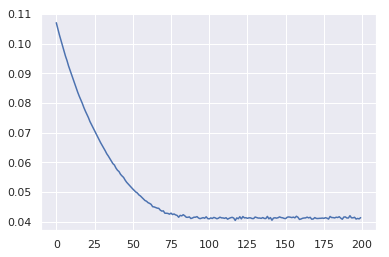

In [309]:
plt.figure()
train_losses_total = [loss['total'] for loss in train_losses_all_epochs]
plt.plot(range(N_EPOCHS), train_losses_total)
print('Last losses:')
print(train_losses_total[-5:])

## Evaluate estimates from standard VAE

In [223]:
print('-- True values of parameters')
for name, param in decoder_true.named_parameters():
    print(name, param.data, '\n')

decoder = modules['decoder']
print('\n-- Learnt values of parameters')
for name, param in decoder.named_parameters():
    print(name, param.data, '\n')

-- True values of parameters
layers.0.weight tensor([[2.]], device='cuda:0') 


-- Learnt values of parameters
layers.0.weight tensor([[-1.1069]], device='cuda:0') 



In [224]:
n_samples = 1000
generated_true_x = generate_from_decoder(decoder_true, n_samples)
generated_x = generate_from_decoder(decoder, n_samples)

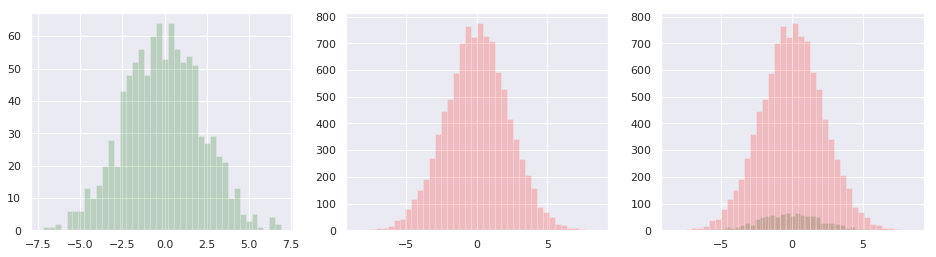

In [323]:
# For 1D
fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(16, 4))
axis_side = 20

ax = axes[0]
toyvis.plot_data(generated_true_x, color='darkgreen', ax=ax)

ax = axes[1]
toyvis.plot_data(generated_x, color='red', ax=ax)

ax = axes[2]
toyvis.plot_data(generated_true_x, color='darkgreen', ax=ax)
toyvis.plot_data(generated_x, color='red', ax=ax)

AttributeError: 'str' object has no attribute 'hist'

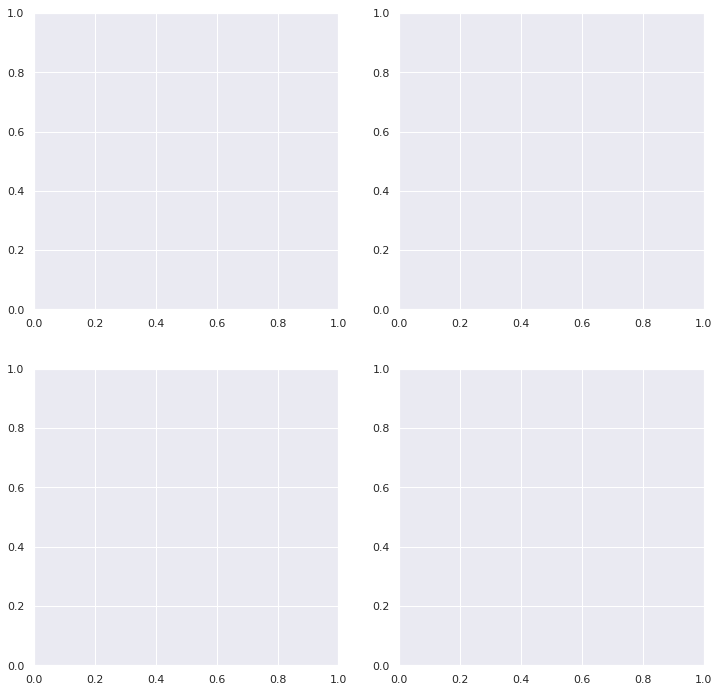

In [241]:
# For 2D
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(12, 12))
axis_side = 20

ax = axes[0, 0]
plot_data(generated_true_x, color='darkgreen')

ax = axes[0, 1]
plot_data(generated_x, color='red')

ax = axes[1, 0]
plot_kde(generated_true_x, ax, 'Greens', axis_side)

ax = axes[1, 1]
plot_kde(generated_x, ax, 'Reds', axis_side)

In [20]:
def risk(theta):
    #loglikelihood_i = ... theta ...

    n_samples = 1000
    generated_true_x = generate_from_decoder(decoder_true, n_samples)
    risk = - np.mean([loglikelihood_i.subs({x_i: sp.Matrix(x_elt)}) for x_elt in generated_true_x])
    return risk

## Train VEM

In [11]:
vae = toynn.VAE(
    latent_dim=latent_dim, data_dim=data_dim, 
    n_layers=n_layers, nonlinearity=nonlinearity)
vae.to(DEVICE)

VAE(
  (encoder): Encoder(
    (fc1): Linear(in_features=2, out_features=1, bias=True)
    (fc2): Linear(in_features=2, out_features=1, bias=True)
  )
  (decoder): Decoder(
    (relu): ReLU()
    (sigmoid): Sigmoid()
    (layers): ModuleList(
      (0): Linear(in_features=1, out_features=2, bias=True)
      (1): Linear(in_features=2, out_features=2, bias=True)
      (2): Linear(in_features=2, out_features=2, bias=True)
    )
  )
)

In [300]:
N_EPOCHS = 200
LR = 1e-4  # TODO: increase LR
BETA1 = 0.5
BETA2 = 0.999

PRINT_INTERVAL = 16


random.seed(0)
np.random.seed(1)
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

vae = toynn.VAE(
    latent_dim=latent_dim, data_dim=data_dim, 
    n_layers=n_layers, nonlinearity=nonlinearity,
    with_biasx=False,
    with_logvarx=False,
    with_biasz=False,
    with_logvarz=False)
vae.to(DEVICE)

discriminator = toynn.Discriminator(data_dim=data_dim).to(DEVICE)

modules = {}
modules['encoder'] = vae.encoder
modules['decoder'] = vae.decoder

modules['discriminator'] = discriminator

print('\n-- Values of parameters before learning')
decoder = modules['decoder']
for name, param in decoder.named_parameters():
    print(name, param.data, '\n')

optimizers = {}
optimizers['encoder'] = torch.optim.Adam(
    modules['encoder'].parameters(), lr=LR, betas=(BETA1, BETA2))
optimizers['decoder'] = torch.optim.Adam(
    modules['decoder'].parameters(), lr=LR, betas=(BETA1, BETA2))

optimizers['discriminator'] = torch.optim.Adam(
    modules['discriminator'].parameters(), lr=LR, betas=(BETA1, BETA2))

def init_xavier_normal(m):
    if type(m) == tnn.Linear:
        tnn.init.xavier_normal_(m.weight)
        
for module in modules.values():
    module.apply(init_xavier_normal)

train_losses_all_epochs = []
test_losses_all_epochs = []

for epoch in range(N_EPOCHS):
    train_losses = toytrain_vem(
        epoch, train_loader, modules, optimizers)
    
    train_losses_all_epochs.append(train_losses)

1

-- Values of parameters before learning
layers.0.weight tensor([[-0.7359]], device='cuda:0') 

tensor(0.3179, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.3187, device='cuda:0', grad_fn=<MeanBackward1>)
Train Epoch: 0 [0/8000 (0%)]	Total Loss: 0.153956
Reconstruction: 0.035497, Regularization: 0.076676, Discriminator: 0.023915; Generator: 0.017868,
D(x): 0.318, D(G(z)): 0.319
tensor(0.3183, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.3197, device='cuda:0', grad_fn=<MeanBackward1>)
Train Epoch: 0 [1024/8000 (13%)]	Total Loss: 0.142510
Reconstruction: 0.032403, Regularization: 0.068371, Discriminator: 0.023916; Generator: 0.017819,
D(x): 0.318, D(G(z)): 0.320
tensor(0.3223, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.3210, device='cuda:0', grad_fn=<MeanBackward1>)
Train Epoch: 0 [2048/8000 (26%)]	Total Loss: 0.134124
Reconstruction: 0.031645, Regularization: 0.060972, Discriminator: 0.023754; Generator: 0.017753,
D(x): 0.322, D(G(z)): 0.321
tensor(0.3194, device='c

tensor(0.3492, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.3471, device='cuda:0', grad_fn=<MeanBackward1>)
Train Epoch: 3 [4096/8000 (51%)]	Total Loss: 0.149177
Reconstruction: 0.035759, Regularization: 0.073773, Discriminator: 0.023111; Generator: 0.016534,
D(x): 0.349, D(G(z)): 0.347
tensor(0.3473, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.3482, device='cuda:0', grad_fn=<MeanBackward1>)
Train Epoch: 3 [5120/8000 (64%)]	Total Loss: 0.160767
Reconstruction: 0.039610, Regularization: 0.081449, Discriminator: 0.023223; Generator: 0.016485,
D(x): 0.347, D(G(z)): 0.348
tensor(0.3490, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.3490, device='cuda:0', grad_fn=<MeanBackward1>)
Train Epoch: 3 [6144/8000 (77%)]	Total Loss: 0.157587
Reconstruction: 0.039010, Regularization: 0.078962, Discriminator: 0.023167; Generator: 0.016447,
D(x): 0.349, D(G(z)): 0.349
tensor(0.3527, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.3503, device='cuda:0', grad_fn=<MeanBackward1>)
Trai

====> Epoch: 6 Average loss: 0.1393
tensor(0.3746, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.3762, device='cuda:0', grad_fn=<MeanBackward1>)
Train Epoch: 7 [0/8000 (0%)]	Total Loss: 0.153691
Reconstruction: 0.039247, Regularization: 0.076442, Discriminator: 0.022725; Generator: 0.015277,
D(x): 0.375, D(G(z)): 0.376
tensor(0.3762, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.3773, device='cuda:0', grad_fn=<MeanBackward1>)
Train Epoch: 7 [1024/8000 (13%)]	Total Loss: 0.142123
Reconstruction: 0.036661, Regularization: 0.067545, Discriminator: 0.022688; Generator: 0.015230,
D(x): 0.376, D(G(z)): 0.377
tensor(0.3812, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.3786, device='cuda:0', grad_fn=<MeanBackward1>)
Train Epoch: 7 [2048/8000 (26%)]	Total Loss: 0.148094
Reconstruction: 0.038858, Regularization: 0.071549, Discriminator: 0.022511; Generator: 0.015176,
D(x): 0.381, D(G(z)): 0.379
tensor(0.3829, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.3796, device='cuda:0

tensor(0.4112, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.4102, device='cuda:0', grad_fn=<MeanBackward1>)
Train Epoch: 10 [4096/8000 (51%)]	Total Loss: 0.127426
Reconstruction: 0.034664, Regularization: 0.056696, Discriminator: 0.022142; Generator: 0.013924,
D(x): 0.411, D(G(z)): 0.410
tensor(0.4108, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.4112, device='cuda:0', grad_fn=<MeanBackward1>)
Train Epoch: 10 [5120/8000 (64%)]	Total Loss: 0.151043
Reconstruction: 0.041335, Regularization: 0.073640, Discriminator: 0.022185; Generator: 0.013884,
D(x): 0.411, D(G(z)): 0.411
tensor(0.4126, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.4125, device='cuda:0', grad_fn=<MeanBackward1>)
Train Epoch: 10 [6144/8000 (77%)]	Total Loss: 0.123645
Reconstruction: 0.033797, Regularization: 0.053864, Discriminator: 0.022147; Generator: 0.013837,
D(x): 0.413, D(G(z)): 0.412
tensor(0.4147, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.4142, device='cuda:0', grad_fn=<MeanBackward1>)
T

====> Epoch: 13 Average loss: 0.1292
tensor(0.4443, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.4445, device='cuda:0', grad_fn=<MeanBackward1>)
Train Epoch: 14 [0/8000 (0%)]	Total Loss: 0.135377
Reconstruction: 0.039480, Regularization: 0.061360, Discriminator: 0.021867; Generator: 0.012669,
D(x): 0.444, D(G(z)): 0.444
tensor(0.4473, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.4456, device='cuda:0', grad_fn=<MeanBackward1>)
Train Epoch: 14 [1024/8000 (13%)]	Total Loss: 0.125867
Reconstruction: 0.036865, Regularization: 0.054581, Discriminator: 0.021789; Generator: 0.012631,
D(x): 0.447, D(G(z)): 0.446
tensor(0.4478, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.4468, device='cuda:0', grad_fn=<MeanBackward1>)
Train Epoch: 14 [2048/8000 (26%)]	Total Loss: 0.124590
Reconstruction: 0.036685, Regularization: 0.053511, Discriminator: 0.021806; Generator: 0.012588,
D(x): 0.448, D(G(z)): 0.447
tensor(0.4493, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.4482, device='cu

tensor(0.4746, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.4739, device='cuda:0', grad_fn=<MeanBackward1>)
Train Epoch: 17 [5120/8000 (64%)]	Total Loss: 0.098375
Reconstruction: 0.030096, Regularization: 0.034929, Discriminator: 0.021684; Generator: 0.011667,
D(x): 0.475, D(G(z)): 0.474
tensor(0.4756, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.4749, device='cuda:0', grad_fn=<MeanBackward1>)
Train Epoch: 17 [6144/8000 (77%)]	Total Loss: 0.104648
Reconstruction: 0.032226, Regularization: 0.039107, Discriminator: 0.021678; Generator: 0.011637,
D(x): 0.476, D(G(z)): 0.475
tensor(0.4755, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.4755, device='cuda:0', grad_fn=<MeanBackward1>)
Train Epoch: 17 [7168/8000 (90%)]	Total Loss: 0.107396
Reconstruction: 0.032873, Regularization: 0.041209, Discriminator: 0.021699; Generator: 0.011615,
D(x): 0.476, D(G(z)): 0.476
====> Epoch: 17 Average loss: 0.1241
tensor(0.4765, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.4762, device

tensor(0.4907, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.4907, device='cuda:0', grad_fn=<MeanBackward1>)
Train Epoch: 21 [1024/8000 (13%)]	Total Loss: 0.126819
Reconstruction: 0.040421, Regularization: 0.053608, Discriminator: 0.021667; Generator: 0.011123,
D(x): 0.491, D(G(z)): 0.491
tensor(0.4915, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.4912, device='cuda:0', grad_fn=<MeanBackward1>)
Train Epoch: 21 [2048/8000 (26%)]	Total Loss: 0.097545
Reconstruction: 0.031222, Regularization: 0.033560, Discriminator: 0.021656; Generator: 0.011107,
D(x): 0.492, D(G(z)): 0.491
tensor(0.4919, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.4915, device='cuda:0', grad_fn=<MeanBackward1>)
Train Epoch: 21 [3072/8000 (38%)]	Total Loss: 0.115387
Reconstruction: 0.037013, Regularization: 0.045622, Discriminator: 0.021654; Generator: 0.011099,
D(x): 0.492, D(G(z)): 0.491
tensor(0.4921, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.4920, device='cuda:0', grad_fn=<MeanBackward1>)
T

tensor(0.4980, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.4979, device='cuda:0', grad_fn=<MeanBackward1>)
Train Epoch: 24 [6144/8000 (77%)]	Total Loss: 0.122423
Reconstruction: 0.040887, Regularization: 0.048981, Discriminator: 0.021661; Generator: 0.010895,
D(x): 0.498, D(G(z)): 0.498
tensor(0.4980, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.4981, device='cuda:0', grad_fn=<MeanBackward1>)
Train Epoch: 24 [7168/8000 (90%)]	Total Loss: 0.104762
Reconstruction: 0.034507, Regularization: 0.037700, Discriminator: 0.021664; Generator: 0.010891,
D(x): 0.498, D(G(z)): 0.498
====> Epoch: 24 Average loss: 0.1173
tensor(0.4980, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.4981, device='cuda:0', grad_fn=<MeanBackward1>)
Train Epoch: 25 [0/8000 (0%)]	Total Loss: 0.112398
Reconstruction: 0.037550, Regularization: 0.042296, Discriminator: 0.021664; Generator: 0.010889,
D(x): 0.498, D(G(z)): 0.498
tensor(0.4983, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.4983, device='cu

tensor(0.4997, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.4997, device='cuda:0', grad_fn=<MeanBackward1>)
Train Epoch: 28 [2048/8000 (26%)]	Total Loss: 0.098599
Reconstruction: 0.033676, Regularization: 0.032423, Discriminator: 0.021661; Generator: 0.010839,
D(x): 0.500, D(G(z)): 0.500
tensor(0.4998, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.4997, device='cuda:0', grad_fn=<MeanBackward1>)
Train Epoch: 28 [3072/8000 (38%)]	Total Loss: 0.118604
Reconstruction: 0.040693, Regularization: 0.045412, Discriminator: 0.021660; Generator: 0.010838,
D(x): 0.500, D(G(z)): 0.500
tensor(0.4998, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.4998, device='cuda:0', grad_fn=<MeanBackward1>)
Train Epoch: 28 [4096/8000 (51%)]	Total Loss: 0.131902
Reconstruction: 0.045555, Regularization: 0.053849, Discriminator: 0.021661; Generator: 0.010838,
D(x): 0.500, D(G(z)): 0.500
tensor(0.4998, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.4998, device='cuda:0', grad_fn=<MeanBackward1>)
T

tensor(0.5000, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.5000, device='cuda:0', grad_fn=<MeanBackward1>)
Train Epoch: 31 [6144/8000 (77%)]	Total Loss: 0.125808
Reconstruction: 0.044865, Regularization: 0.048451, Discriminator: 0.021663; Generator: 0.010829,
D(x): 0.500, D(G(z)): 0.500
tensor(0.5001, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.5000, device='cuda:0', grad_fn=<MeanBackward1>)
Train Epoch: 31 [7168/8000 (90%)]	Total Loss: 0.108383
Reconstruction: 0.038879, Regularization: 0.037015, Discriminator: 0.021659; Generator: 0.010831,
D(x): 0.500, D(G(z)): 0.500
====> Epoch: 31 Average loss: 0.1117
tensor(0.5001, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.5000, device='cuda:0', grad_fn=<MeanBackward1>)
Train Epoch: 32 [0/8000 (0%)]	Total Loss: 0.112961
Reconstruction: 0.040200, Regularization: 0.040273, Discriminator: 0.021658; Generator: 0.010830,
D(x): 0.500, D(G(z)): 0.500
tensor(0.4999, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.5000, device='cu

tensor(0.5008, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.5000, device='cuda:0', grad_fn=<MeanBackward1>)
Train Epoch: 35 [3072/8000 (38%)]	Total Loss: 0.102461
Reconstruction: 0.037461, Regularization: 0.032534, Discriminator: 0.021635; Generator: 0.010831,
D(x): 0.501, D(G(z)): 0.500
tensor(0.5002, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.5001, device='cuda:0', grad_fn=<MeanBackward1>)
Train Epoch: 35 [4096/8000 (51%)]	Total Loss: 0.088139
Reconstruction: 0.032252, Regularization: 0.023403, Discriminator: 0.021656; Generator: 0.010828,
D(x): 0.500, D(G(z)): 0.500
tensor(0.4994, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.5001, device='cuda:0', grad_fn=<MeanBackward1>)
Train Epoch: 35 [5120/8000 (64%)]	Total Loss: 0.100038
Reconstruction: 0.035654, Regularization: 0.031874, Discriminator: 0.021682; Generator: 0.010827,
D(x): 0.499, D(G(z)): 0.500
tensor(0.5000, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.5000, device='cuda:0', grad_fn=<MeanBackward1>)
T

tensor(0.5011, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.5001, device='cuda:0', grad_fn=<MeanBackward1>)
Train Epoch: 38 [7168/8000 (90%)]	Total Loss: 0.115410
Reconstruction: 0.044837, Regularization: 0.038115, Discriminator: 0.021630; Generator: 0.010828,
D(x): 0.501, D(G(z)): 0.500
====> Epoch: 38 Average loss: 0.1070
tensor(0.5003, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.5001, device='cuda:0', grad_fn=<MeanBackward1>)
Train Epoch: 39 [0/8000 (0%)]	Total Loss: 0.091335
Reconstruction: 0.033692, Regularization: 0.025161, Discriminator: 0.021653; Generator: 0.010828,
D(x): 0.500, D(G(z)): 0.500
tensor(0.5002, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.5001, device='cuda:0', grad_fn=<MeanBackward1>)
Train Epoch: 39 [1024/8000 (13%)]	Total Loss: 0.103272
Reconstruction: 0.038840, Regularization: 0.031946, Discriminator: 0.021659; Generator: 0.010827,
D(x): 0.500, D(G(z)): 0.500
tensor(0.5002, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.5001, device='cu

tensor(0.4994, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.5001, device='cuda:0', grad_fn=<MeanBackward1>)
Train Epoch: 42 [3072/8000 (38%)]	Total Loss: 0.105797
Reconstruction: 0.042497, Regularization: 0.030791, Discriminator: 0.021682; Generator: 0.010827,
D(x): 0.499, D(G(z)): 0.500
tensor(0.5010, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.5000, device='cuda:0', grad_fn=<MeanBackward1>)
Train Epoch: 42 [4096/8000 (51%)]	Total Loss: 0.105994
Reconstruction: 0.041971, Regularization: 0.031560, Discriminator: 0.021631; Generator: 0.010831,
D(x): 0.501, D(G(z)): 0.500
tensor(0.4988, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.5000, device='cuda:0', grad_fn=<MeanBackward1>)
Train Epoch: 42 [5120/8000 (64%)]	Total Loss: 0.098269
Reconstruction: 0.038664, Regularization: 0.027075, Discriminator: 0.021699; Generator: 0.010831,
D(x): 0.499, D(G(z)): 0.500
tensor(0.5000, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.4999, device='cuda:0', grad_fn=<MeanBackward1>)
T

tensor(0.5008, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.4999, device='cuda:0', grad_fn=<MeanBackward1>)
Train Epoch: 45 [7168/8000 (90%)]	Total Loss: 0.115865
Reconstruction: 0.048846, Regularization: 0.034549, Discriminator: 0.021637; Generator: 0.010832,
D(x): 0.501, D(G(z)): 0.500
====> Epoch: 45 Average loss: 0.1028
tensor(0.4997, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.5001, device='cuda:0', grad_fn=<MeanBackward1>)
Train Epoch: 46 [0/8000 (0%)]	Total Loss: 0.115304
Reconstruction: 0.048335, Regularization: 0.034466, Discriminator: 0.021676; Generator: 0.010827,
D(x): 0.500, D(G(z)): 0.500
tensor(0.5007, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.5000, device='cuda:0', grad_fn=<MeanBackward1>)
Train Epoch: 46 [1024/8000 (13%)]	Total Loss: 0.093299
Reconstruction: 0.037006, Regularization: 0.023824, Discriminator: 0.021638; Generator: 0.010832,
D(x): 0.501, D(G(z)): 0.500
tensor(0.4994, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.4999, device='cu

tensor(0.4993, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.4999, device='cuda:0', grad_fn=<MeanBackward1>)
Train Epoch: 49 [3072/8000 (38%)]	Total Loss: 0.090596
Reconstruction: 0.036583, Regularization: 0.021500, Discriminator: 0.021680; Generator: 0.010833,
D(x): 0.499, D(G(z)): 0.500
tensor(0.4998, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.4999, device='cuda:0', grad_fn=<MeanBackward1>)
Train Epoch: 49 [4096/8000 (51%)]	Total Loss: 0.114515
Reconstruction: 0.049258, Regularization: 0.032756, Discriminator: 0.021666; Generator: 0.010835,
D(x): 0.500, D(G(z)): 0.500
tensor(0.5001, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.5001, device='cuda:0', grad_fn=<MeanBackward1>)
Train Epoch: 49 [5120/8000 (64%)]	Total Loss: 0.084192
Reconstruction: 0.033727, Regularization: 0.017974, Discriminator: 0.021663; Generator: 0.010828,
D(x): 0.500, D(G(z)): 0.500
tensor(0.5000, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.5000, device='cuda:0', grad_fn=<MeanBackward1>)
T

tensor(0.5008, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.4999, device='cuda:0', grad_fn=<MeanBackward1>)
Train Epoch: 52 [7168/8000 (90%)]	Total Loss: 0.099134
Reconstruction: 0.043398, Regularization: 0.023269, Discriminator: 0.021634; Generator: 0.010834,
D(x): 0.501, D(G(z)): 0.500
====> Epoch: 52 Average loss: 0.0992
tensor(0.4999, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.4999, device='cuda:0', grad_fn=<MeanBackward1>)
Train Epoch: 53 [0/8000 (0%)]	Total Loss: 0.089873
Reconstruction: 0.037570, Regularization: 0.019806, Discriminator: 0.021662; Generator: 0.010835,
D(x): 0.500, D(G(z)): 0.500
tensor(0.4995, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.4998, device='cuda:0', grad_fn=<MeanBackward1>)
Train Epoch: 53 [1024/8000 (13%)]	Total Loss: 0.107242
Reconstruction: 0.047898, Regularization: 0.026835, Discriminator: 0.021673; Generator: 0.010836,
D(x): 0.500, D(G(z)): 0.500
tensor(0.4992, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.5000, device='cu

tensor(0.4996, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.4997, device='cuda:0', grad_fn=<MeanBackward1>)
Train Epoch: 56 [3072/8000 (38%)]	Total Loss: 0.101487
Reconstruction: 0.045706, Regularization: 0.023275, Discriminator: 0.021668; Generator: 0.010839,
D(x): 0.500, D(G(z)): 0.500
tensor(0.5004, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.5001, device='cuda:0', grad_fn=<MeanBackward1>)
Train Epoch: 56 [4096/8000 (51%)]	Total Loss: 0.094338
Reconstruction: 0.042203, Regularization: 0.019653, Discriminator: 0.021654; Generator: 0.010828,
D(x): 0.500, D(G(z)): 0.500
tensor(0.4995, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.5000, device='cuda:0', grad_fn=<MeanBackward1>)
Train Epoch: 56 [5120/8000 (64%)]	Total Loss: 0.086399
Reconstruction: 0.037157, Regularization: 0.016735, Discriminator: 0.021676; Generator: 0.010832,
D(x): 0.500, D(G(z)): 0.500
tensor(0.5016, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.4998, device='cuda:0', grad_fn=<MeanBackward1>)
T

tensor(0.5006, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.4998, device='cuda:0', grad_fn=<MeanBackward1>)
Train Epoch: 59 [7168/8000 (90%)]	Total Loss: 0.082081
Reconstruction: 0.035791, Regularization: 0.013817, Discriminator: 0.021636; Generator: 0.010837,
D(x): 0.501, D(G(z)): 0.500
====> Epoch: 59 Average loss: 0.0958
tensor(0.5003, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.4999, device='cuda:0', grad_fn=<MeanBackward1>)
Train Epoch: 60 [0/8000 (0%)]	Total Loss: 0.090142
Reconstruction: 0.040645, Regularization: 0.017013, Discriminator: 0.021649; Generator: 0.010835,
D(x): 0.500, D(G(z)): 0.500
tensor(0.4990, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.4999, device='cuda:0', grad_fn=<MeanBackward1>)
Train Epoch: 60 [1024/8000 (13%)]	Total Loss: 0.089695
Reconstruction: 0.040236, Regularization: 0.016934, Discriminator: 0.021692; Generator: 0.010833,
D(x): 0.499, D(G(z)): 0.500
tensor(0.4996, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.5001, device='cu

tensor(0.5014, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.4999, device='cuda:0', grad_fn=<MeanBackward1>)
Train Epoch: 63 [3072/8000 (38%)]	Total Loss: 0.098643
Reconstruction: 0.047062, Regularization: 0.019130, Discriminator: 0.021618; Generator: 0.010833,
D(x): 0.501, D(G(z)): 0.500
tensor(0.5010, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.5000, device='cuda:0', grad_fn=<MeanBackward1>)
Train Epoch: 63 [4096/8000 (51%)]	Total Loss: 0.095769
Reconstruction: 0.045840, Regularization: 0.017468, Discriminator: 0.021631; Generator: 0.010831,
D(x): 0.501, D(G(z)): 0.500
tensor(0.4998, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.4998, device='cuda:0', grad_fn=<MeanBackward1>)
Train Epoch: 63 [5120/8000 (64%)]	Total Loss: 0.114212
Reconstruction: 0.057098, Regularization: 0.024612, Discriminator: 0.021665; Generator: 0.010836,
D(x): 0.500, D(G(z)): 0.500
tensor(0.4996, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.5000, device='cuda:0', grad_fn=<MeanBackward1>)
T

tensor(0.5019, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.4998, device='cuda:0', grad_fn=<MeanBackward1>)
Train Epoch: 66 [7168/8000 (90%)]	Total Loss: 0.076940
Reconstruction: 0.034211, Regularization: 0.010294, Discriminator: 0.021599; Generator: 0.010835,
D(x): 0.502, D(G(z)): 0.500
====> Epoch: 66 Average loss: 0.0930
tensor(0.4990, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.4999, device='cuda:0', grad_fn=<MeanBackward1>)
Train Epoch: 67 [0/8000 (0%)]	Total Loss: 0.097247
Reconstruction: 0.047650, Regularization: 0.017071, Discriminator: 0.021693; Generator: 0.010833,
D(x): 0.499, D(G(z)): 0.500
tensor(0.5009, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.5000, device='cuda:0', grad_fn=<MeanBackward1>)
Train Epoch: 67 [1024/8000 (13%)]	Total Loss: 0.095318
Reconstruction: 0.046535, Regularization: 0.016318, Discriminator: 0.021635; Generator: 0.010831,
D(x): 0.501, D(G(z)): 0.500
tensor(0.4983, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.5000, device='cu

tensor(0.4996, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.5001, device='cuda:0', grad_fn=<MeanBackward1>)
Train Epoch: 70 [3072/8000 (38%)]	Total Loss: 0.094334
Reconstruction: 0.047443, Regularization: 0.014384, Discriminator: 0.021679; Generator: 0.010828,
D(x): 0.500, D(G(z)): 0.500
tensor(0.4988, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.4998, device='cuda:0', grad_fn=<MeanBackward1>)
Train Epoch: 70 [4096/8000 (51%)]	Total Loss: 0.090050
Reconstruction: 0.044563, Regularization: 0.012957, Discriminator: 0.021695; Generator: 0.010835,
D(x): 0.499, D(G(z)): 0.500
tensor(0.4995, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.4998, device='cuda:0', grad_fn=<MeanBackward1>)
Train Epoch: 70 [5120/8000 (64%)]	Total Loss: 0.086469
Reconstruction: 0.041873, Regularization: 0.012085, Discriminator: 0.021675; Generator: 0.010836,
D(x): 0.499, D(G(z)): 0.500
tensor(0.5015, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.4999, device='cuda:0', grad_fn=<MeanBackward1>)
T

====> Epoch: 73 Average loss: 0.0907
tensor(0.4993, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.5000, device='cuda:0', grad_fn=<MeanBackward1>)
Train Epoch: 74 [0/8000 (0%)]	Total Loss: 0.094855
Reconstruction: 0.049297, Regularization: 0.013040, Discriminator: 0.021685; Generator: 0.010832,
D(x): 0.499, D(G(z)): 0.500
tensor(0.5005, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.5000, device='cuda:0', grad_fn=<MeanBackward1>)
Train Epoch: 74 [1024/8000 (13%)]	Total Loss: 0.083101
Reconstruction: 0.040653, Regularization: 0.009970, Discriminator: 0.021647; Generator: 0.010832,
D(x): 0.500, D(G(z)): 0.500
tensor(0.5013, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.4999, device='cuda:0', grad_fn=<MeanBackward1>)
Train Epoch: 74 [2048/8000 (26%)]	Total Loss: 0.100336
Reconstruction: 0.052734, Regularization: 0.015149, Discriminator: 0.021620; Generator: 0.010833,
D(x): 0.501, D(G(z)): 0.500
tensor(0.5011, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.4998, device='cu

tensor(0.5030, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.4999, device='cuda:0', grad_fn=<MeanBackward1>)
Train Epoch: 77 [4096/8000 (51%)]	Total Loss: 0.099307
Reconstruction: 0.054157, Regularization: 0.012748, Discriminator: 0.021570; Generator: 0.010832,
D(x): 0.503, D(G(z)): 0.500
tensor(0.4993, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.5000, device='cuda:0', grad_fn=<MeanBackward1>)
Train Epoch: 77 [5120/8000 (64%)]	Total Loss: 0.087256
Reconstruction: 0.044727, Regularization: 0.010012, Discriminator: 0.021686; Generator: 0.010831,
D(x): 0.499, D(G(z)): 0.500
tensor(0.4979, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.5001, device='cuda:0', grad_fn=<MeanBackward1>)
Train Epoch: 77 [6144/8000 (77%)]	Total Loss: 0.083668
Reconstruction: 0.042021, Regularization: 0.009087, Discriminator: 0.021731; Generator: 0.010829,
D(x): 0.498, D(G(z)): 0.500
tensor(0.5014, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.4997, device='cuda:0', grad_fn=<MeanBackward1>)
T

====> Epoch: 80 Average loss: 0.0888
tensor(0.4986, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.4998, device='cuda:0', grad_fn=<MeanBackward1>)
Train Epoch: 81 [0/8000 (0%)]	Total Loss: 0.084474
Reconstruction: 0.043420, Regularization: 0.008516, Discriminator: 0.021700; Generator: 0.010838,
D(x): 0.499, D(G(z)): 0.500
tensor(0.4992, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.4999, device='cuda:0', grad_fn=<MeanBackward1>)
Train Epoch: 81 [1024/8000 (13%)]	Total Loss: 0.095734
Reconstruction: 0.052442, Regularization: 0.010774, Discriminator: 0.021686; Generator: 0.010833,
D(x): 0.499, D(G(z)): 0.500
tensor(0.4999, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.4999, device='cuda:0', grad_fn=<MeanBackward1>)
Train Epoch: 81 [2048/8000 (26%)]	Total Loss: 0.087475
Reconstruction: 0.046120, Regularization: 0.008857, Discriminator: 0.021665; Generator: 0.010832,
D(x): 0.500, D(G(z)): 0.500
tensor(0.5010, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.4999, device='cu

tensor(0.4988, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.4999, device='cuda:0', grad_fn=<MeanBackward1>)
Train Epoch: 84 [4096/8000 (51%)]	Total Loss: 0.088194
Reconstruction: 0.047632, Regularization: 0.008031, Discriminator: 0.021699; Generator: 0.010833,
D(x): 0.499, D(G(z)): 0.500
tensor(0.4993, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.4998, device='cuda:0', grad_fn=<MeanBackward1>)
Train Epoch: 84 [5120/8000 (64%)]	Total Loss: 0.080756
Reconstruction: 0.041587, Regularization: 0.006652, Discriminator: 0.021680; Generator: 0.010837,
D(x): 0.499, D(G(z)): 0.500
tensor(0.5010, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.5000, device='cuda:0', grad_fn=<MeanBackward1>)
Train Epoch: 84 [6144/8000 (77%)]	Total Loss: 0.087236
Reconstruction: 0.047015, Regularization: 0.007758, Discriminator: 0.021633; Generator: 0.010830,
D(x): 0.501, D(G(z)): 0.500
tensor(0.5020, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.4999, device='cuda:0', grad_fn=<MeanBackward1>)
T

====> Epoch: 87 Average loss: 0.0873
tensor(0.5014, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.4997, device='cuda:0', grad_fn=<MeanBackward1>)
Train Epoch: 88 [0/8000 (0%)]	Total Loss: 0.096270
Reconstruction: 0.055204, Regularization: 0.008615, Discriminator: 0.021611; Generator: 0.010840,
D(x): 0.501, D(G(z)): 0.500
tensor(0.5000, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.4998, device='cuda:0', grad_fn=<MeanBackward1>)
Train Epoch: 88 [1024/8000 (13%)]	Total Loss: 0.086998
Reconstruction: 0.047681, Regularization: 0.006823, Discriminator: 0.021659; Generator: 0.010837,
D(x): 0.500, D(G(z)): 0.500
tensor(0.4997, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.4999, device='cuda:0', grad_fn=<MeanBackward1>)
Train Epoch: 88 [2048/8000 (26%)]	Total Loss: 0.097806
Reconstruction: 0.056727, Regularization: 0.008574, Discriminator: 0.021671; Generator: 0.010833,
D(x): 0.500, D(G(z)): 0.500
tensor(0.5010, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.4997, device='cu

tensor(0.4994, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.5000, device='cuda:0', grad_fn=<MeanBackward1>)
Train Epoch: 91 [4096/8000 (51%)]	Total Loss: 0.079679
Reconstruction: 0.042162, Regularization: 0.005002, Discriminator: 0.021682; Generator: 0.010832,
D(x): 0.499, D(G(z)): 0.500
tensor(0.5013, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.4997, device='cuda:0', grad_fn=<MeanBackward1>)
Train Epoch: 91 [5120/8000 (64%)]	Total Loss: 0.087226
Reconstruction: 0.048961, Regularization: 0.005812, Discriminator: 0.021613; Generator: 0.010839,
D(x): 0.501, D(G(z)): 0.500
tensor(0.5005, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.4998, device='cuda:0', grad_fn=<MeanBackward1>)
Train Epoch: 91 [6144/8000 (77%)]	Total Loss: 0.088020
Reconstruction: 0.049644, Regularization: 0.005898, Discriminator: 0.021641; Generator: 0.010837,
D(x): 0.501, D(G(z)): 0.500
tensor(0.4992, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.4998, device='cuda:0', grad_fn=<MeanBackward1>)
T

====> Epoch: 94 Average loss: 0.0860
tensor(0.4999, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.5000, device='cuda:0', grad_fn=<MeanBackward1>)
Train Epoch: 95 [0/8000 (0%)]	Total Loss: 0.075393
Reconstruction: 0.039238, Regularization: 0.003657, Discriminator: 0.021669; Generator: 0.010829,
D(x): 0.500, D(G(z)): 0.500
tensor(0.5009, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.5000, device='cuda:0', grad_fn=<MeanBackward1>)
Train Epoch: 95 [1024/8000 (13%)]	Total Loss: 0.084853
Reconstruction: 0.047673, Regularization: 0.004713, Discriminator: 0.021636; Generator: 0.010831,
D(x): 0.501, D(G(z)): 0.500
tensor(0.5012, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.4999, device='cuda:0', grad_fn=<MeanBackward1>)
Train Epoch: 95 [2048/8000 (26%)]	Total Loss: 0.094005
Reconstruction: 0.055697, Regularization: 0.005851, Discriminator: 0.021622; Generator: 0.010835,
D(x): 0.501, D(G(z)): 0.500
tensor(0.5020, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.5000, device='cu

tensor(0.5012, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.5000, device='cuda:0', grad_fn=<MeanBackward1>)
Train Epoch: 98 [4096/8000 (51%)]	Total Loss: 0.094518
Reconstruction: 0.056837, Regularization: 0.005224, Discriminator: 0.021627; Generator: 0.010830,
D(x): 0.501, D(G(z)): 0.500
tensor(0.5001, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.4999, device='cuda:0', grad_fn=<MeanBackward1>)
Train Epoch: 98 [5120/8000 (64%)]	Total Loss: 0.081186
Reconstruction: 0.044865, Regularization: 0.003831, Discriminator: 0.021656; Generator: 0.010835,
D(x): 0.500, D(G(z)): 0.500
tensor(0.4995, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.5000, device='cuda:0', grad_fn=<MeanBackward1>)
Train Epoch: 98 [6144/8000 (77%)]	Total Loss: 0.088197
Reconstruction: 0.051236, Regularization: 0.004451, Discriminator: 0.021680; Generator: 0.010830,
D(x): 0.500, D(G(z)): 0.500
tensor(0.5000, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.5000, device='cuda:0', grad_fn=<MeanBackward1>)
T

====> Epoch: 101 Average loss: 0.0854
tensor(0.4996, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.4997, device='cuda:0', grad_fn=<MeanBackward1>)
Train Epoch: 102 [0/8000 (0%)]	Total Loss: 0.083127
Reconstruction: 0.047170, Regularization: 0.003450, Discriminator: 0.021669; Generator: 0.010839,
D(x): 0.500, D(G(z)): 0.500
tensor(0.4994, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.5000, device='cuda:0', grad_fn=<MeanBackward1>)
Train Epoch: 102 [1024/8000 (13%)]	Total Loss: 0.092960
Reconstruction: 0.056237, Regularization: 0.004210, Discriminator: 0.021683; Generator: 0.010831,
D(x): 0.499, D(G(z)): 0.500
tensor(0.4997, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.5000, device='cuda:0', grad_fn=<MeanBackward1>)
Train Epoch: 102 [2048/8000 (26%)]	Total Loss: 0.075686
Reconstruction: 0.040537, Regularization: 0.002645, Discriminator: 0.021673; Generator: 0.010830,
D(x): 0.500, D(G(z)): 0.500
tensor(0.5016, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.4998, device

tensor(0.5007, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.4999, device='cuda:0', grad_fn=<MeanBackward1>)
Train Epoch: 105 [4096/8000 (51%)]	Total Loss: 0.078550
Reconstruction: 0.043617, Regularization: 0.002459, Discriminator: 0.021639; Generator: 0.010834,
D(x): 0.501, D(G(z)): 0.500
tensor(0.4989, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.5000, device='cuda:0', grad_fn=<MeanBackward1>)
Train Epoch: 105 [5120/8000 (64%)]	Total Loss: 0.083833
Reconstruction: 0.048395, Regularization: 0.002911, Discriminator: 0.021698; Generator: 0.010830,
D(x): 0.499, D(G(z)): 0.500
tensor(0.5001, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.5001, device='cuda:0', grad_fn=<MeanBackward1>)
Train Epoch: 105 [6144/8000 (77%)]	Total Loss: 0.083726
Reconstruction: 0.048320, Regularization: 0.002914, Discriminator: 0.021664; Generator: 0.010829,
D(x): 0.500, D(G(z)): 0.500
tensor(0.5004, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.4998, device='cuda:0', grad_fn=<MeanBackward1>

====> Epoch: 108 Average loss: 0.0848
tensor(0.5015, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.4998, device='cuda:0', grad_fn=<MeanBackward1>)
Train Epoch: 109 [0/8000 (0%)]	Total Loss: 0.087928
Reconstruction: 0.052760, Regularization: 0.002720, Discriminator: 0.021612; Generator: 0.010836,
D(x): 0.502, D(G(z)): 0.500
tensor(0.4985, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.4997, device='cuda:0', grad_fn=<MeanBackward1>)
Train Epoch: 109 [1024/8000 (13%)]	Total Loss: 0.081305
Reconstruction: 0.046463, Regularization: 0.002299, Discriminator: 0.021704; Generator: 0.010839,
D(x): 0.498, D(G(z)): 0.500
tensor(0.4994, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.5000, device='cuda:0', grad_fn=<MeanBackward1>)
Train Epoch: 109 [2048/8000 (26%)]	Total Loss: 0.088122
Reconstruction: 0.052970, Regularization: 0.002638, Discriminator: 0.021684; Generator: 0.010830,
D(x): 0.499, D(G(z)): 0.500
tensor(0.5001, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.4999, device

tensor(0.5006, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.4998, device='cuda:0', grad_fn=<MeanBackward1>)
Train Epoch: 112 [4096/8000 (51%)]	Total Loss: 0.077847
Reconstruction: 0.043614, Regularization: 0.001758, Discriminator: 0.021638; Generator: 0.010837,
D(x): 0.501, D(G(z)): 0.500
tensor(0.5030, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.4998, device='cuda:0', grad_fn=<MeanBackward1>)
Train Epoch: 112 [5120/8000 (64%)]	Total Loss: 0.089457
Reconstruction: 0.054679, Regularization: 0.002379, Discriminator: 0.021563; Generator: 0.010836,
D(x): 0.503, D(G(z)): 0.500
tensor(0.5012, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.5000, device='cuda:0', grad_fn=<MeanBackward1>)
Train Epoch: 112 [6144/8000 (77%)]	Total Loss: 0.096679
Reconstruction: 0.061473, Regularization: 0.002747, Discriminator: 0.021628; Generator: 0.010831,
D(x): 0.501, D(G(z)): 0.500
tensor(0.4999, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.5001, device='cuda:0', grad_fn=<MeanBackward1>

====> Epoch: 115 Average loss: 0.0846
tensor(0.4998, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.4998, device='cuda:0', grad_fn=<MeanBackward1>)
Train Epoch: 116 [0/8000 (0%)]	Total Loss: 0.087810
Reconstruction: 0.053347, Regularization: 0.001964, Discriminator: 0.021665; Generator: 0.010835,
D(x): 0.500, D(G(z)): 0.500
tensor(0.5011, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.5000, device='cuda:0', grad_fn=<MeanBackward1>)
Train Epoch: 116 [1024/8000 (13%)]	Total Loss: 0.085445
Reconstruction: 0.051159, Regularization: 0.001827, Discriminator: 0.021630; Generator: 0.010829,
D(x): 0.501, D(G(z)): 0.500
tensor(0.4998, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.5000, device='cuda:0', grad_fn=<MeanBackward1>)
Train Epoch: 116 [2048/8000 (26%)]	Total Loss: 0.089847
Reconstruction: 0.055271, Regularization: 0.002074, Discriminator: 0.021671; Generator: 0.010832,
D(x): 0.500, D(G(z)): 0.500
tensor(0.5005, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.4999, device

tensor(0.4995, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.4999, device='cuda:0', grad_fn=<MeanBackward1>)
Train Epoch: 119 [4096/8000 (51%)]	Total Loss: 0.088294
Reconstruction: 0.054132, Regularization: 0.001650, Discriminator: 0.021678; Generator: 0.010834,
D(x): 0.499, D(G(z)): 0.500
tensor(0.5008, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.4998, device='cuda:0', grad_fn=<MeanBackward1>)
Train Epoch: 119 [5120/8000 (64%)]	Total Loss: 0.084710
Reconstruction: 0.050711, Regularization: 0.001530, Discriminator: 0.021633; Generator: 0.010836,
D(x): 0.501, D(G(z)): 0.500
tensor(0.5006, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.4999, device='cuda:0', grad_fn=<MeanBackward1>)
Train Epoch: 119 [6144/8000 (77%)]	Total Loss: 0.108194
Reconstruction: 0.073306, Regularization: 0.002411, Discriminator: 0.021645; Generator: 0.010832,
D(x): 0.501, D(G(z)): 0.500
tensor(0.5025, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.4999, device='cuda:0', grad_fn=<MeanBackward1>

====> Epoch: 122 Average loss: 0.0846
tensor(0.5012, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.4999, device='cuda:0', grad_fn=<MeanBackward1>)
Train Epoch: 123 [0/8000 (0%)]	Total Loss: 0.084261
Reconstruction: 0.050491, Regularization: 0.001312, Discriminator: 0.021625; Generator: 0.010833,
D(x): 0.501, D(G(z)): 0.500
tensor(0.4997, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.4998, device='cuda:0', grad_fn=<MeanBackward1>)
Train Epoch: 123 [1024/8000 (13%)]	Total Loss: 0.081215
Reconstruction: 0.047479, Regularization: 0.001232, Discriminator: 0.021666; Generator: 0.010838,
D(x): 0.500, D(G(z)): 0.500
tensor(0.4997, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.4998, device='cuda:0', grad_fn=<MeanBackward1>)
Train Epoch: 123 [2048/8000 (26%)]	Total Loss: 0.083974
Reconstruction: 0.050101, Regularization: 0.001369, Discriminator: 0.021669; Generator: 0.010835,
D(x): 0.500, D(G(z)): 0.500
tensor(0.5013, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.4998, device

tensor(0.4996, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.4998, device='cuda:0', grad_fn=<MeanBackward1>)
Train Epoch: 126 [4096/8000 (51%)]	Total Loss: 0.082273
Reconstruction: 0.048608, Regularization: 0.001159, Discriminator: 0.021671; Generator: 0.010836,
D(x): 0.500, D(G(z)): 0.500
tensor(0.5002, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.4998, device='cuda:0', grad_fn=<MeanBackward1>)
Train Epoch: 126 [5120/8000 (64%)]	Total Loss: 0.079076
Reconstruction: 0.045541, Regularization: 0.001047, Discriminator: 0.021652; Generator: 0.010837,
D(x): 0.500, D(G(z)): 0.500
tensor(0.4991, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.4999, device='cuda:0', grad_fn=<MeanBackward1>)
Train Epoch: 126 [6144/8000 (77%)]	Total Loss: 0.077467
Reconstruction: 0.043930, Regularization: 0.001012, Discriminator: 0.021690; Generator: 0.010834,
D(x): 0.499, D(G(z)): 0.500
tensor(0.4974, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.4998, device='cuda:0', grad_fn=<MeanBackward1>

====> Epoch: 129 Average loss: 0.0847
tensor(0.5004, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.4998, device='cuda:0', grad_fn=<MeanBackward1>)
Train Epoch: 130 [0/8000 (0%)]	Total Loss: 0.091015
Reconstruction: 0.057121, Regularization: 0.001412, Discriminator: 0.021645; Generator: 0.010838,
D(x): 0.500, D(G(z)): 0.500
tensor(0.4999, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.4998, device='cuda:0', grad_fn=<MeanBackward1>)
Train Epoch: 130 [1024/8000 (13%)]	Total Loss: 0.083875
Reconstruction: 0.050251, Regularization: 0.001127, Discriminator: 0.021659; Generator: 0.010838,
D(x): 0.500, D(G(z)): 0.500
tensor(0.4986, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.5000, device='cuda:0', grad_fn=<MeanBackward1>)
Train Epoch: 130 [2048/8000 (26%)]	Total Loss: 0.081601
Reconstruction: 0.047992, Regularization: 0.001071, Discriminator: 0.021706; Generator: 0.010832,
D(x): 0.499, D(G(z)): 0.500
tensor(0.4993, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.4997, device

tensor(0.4999, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.4999, device='cuda:0', grad_fn=<MeanBackward1>)
Train Epoch: 133 [4096/8000 (51%)]	Total Loss: 0.095315
Reconstruction: 0.061370, Regularization: 0.001445, Discriminator: 0.021667; Generator: 0.010833,
D(x): 0.500, D(G(z)): 0.500
tensor(0.5007, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.4999, device='cuda:0', grad_fn=<MeanBackward1>)
Train Epoch: 133 [5120/8000 (64%)]	Total Loss: 0.085813
Reconstruction: 0.052177, Regularization: 0.001164, Discriminator: 0.021639; Generator: 0.010833,
D(x): 0.501, D(G(z)): 0.500
tensor(0.5030, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.4997, device='cuda:0', grad_fn=<MeanBackward1>)
Train Epoch: 133 [6144/8000 (77%)]	Total Loss: 0.095637
Reconstruction: 0.061761, Regularization: 0.001476, Discriminator: 0.021561; Generator: 0.010840,
D(x): 0.503, D(G(z)): 0.500
tensor(0.5007, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.4998, device='cuda:0', grad_fn=<MeanBackward1>

====> Epoch: 136 Average loss: 0.0846
tensor(0.4996, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.4999, device='cuda:0', grad_fn=<MeanBackward1>)
Train Epoch: 137 [0/8000 (0%)]	Total Loss: 0.082144
Reconstruction: 0.048593, Regularization: 0.001043, Discriminator: 0.021674; Generator: 0.010834,
D(x): 0.500, D(G(z)): 0.500
tensor(0.5014, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.4999, device='cuda:0', grad_fn=<MeanBackward1>)
Train Epoch: 137 [1024/8000 (13%)]	Total Loss: 0.090861
Reconstruction: 0.057089, Regularization: 0.001321, Discriminator: 0.021617; Generator: 0.010834,
D(x): 0.501, D(G(z)): 0.500
tensor(0.5014, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.5001, device='cuda:0', grad_fn=<MeanBackward1>)
Train Epoch: 137 [2048/8000 (26%)]	Total Loss: 0.090939
Reconstruction: 0.057165, Regularization: 0.001322, Discriminator: 0.021623; Generator: 0.010829,
D(x): 0.501, D(G(z)): 0.500
tensor(0.5000, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.4998, device

tensor(0.5005, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.4999, device='cuda:0', grad_fn=<MeanBackward1>)
Train Epoch: 140 [4096/8000 (51%)]	Total Loss: 0.092252
Reconstruction: 0.058424, Regularization: 0.001349, Discriminator: 0.021646; Generator: 0.010833,
D(x): 0.501, D(G(z)): 0.500
tensor(0.5018, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.4998, device='cuda:0', grad_fn=<MeanBackward1>)
Train Epoch: 140 [5120/8000 (64%)]	Total Loss: 0.081646
Reconstruction: 0.048174, Regularization: 0.001034, Discriminator: 0.021603; Generator: 0.010835,
D(x): 0.502, D(G(z)): 0.500
tensor(0.4987, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.4999, device='cuda:0', grad_fn=<MeanBackward1>)
Train Epoch: 140 [6144/8000 (77%)]	Total Loss: 0.082565
Reconstruction: 0.048959, Regularization: 0.001072, Discriminator: 0.021701; Generator: 0.010834,
D(x): 0.499, D(G(z)): 0.500
tensor(0.5015, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.4999, device='cuda:0', grad_fn=<MeanBackward1>

====> Epoch: 143 Average loss: 0.0846
tensor(0.5010, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.5000, device='cuda:0', grad_fn=<MeanBackward1>)
Train Epoch: 144 [0/8000 (0%)]	Total Loss: 0.088620
Reconstruction: 0.054887, Regularization: 0.001267, Discriminator: 0.021636; Generator: 0.010829,
D(x): 0.501, D(G(z)): 0.500
tensor(0.5013, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.4997, device='cuda:0', grad_fn=<MeanBackward1>)
Train Epoch: 144 [1024/8000 (13%)]	Total Loss: 0.094213
Reconstruction: 0.060308, Regularization: 0.001449, Discriminator: 0.021616; Generator: 0.010840,
D(x): 0.501, D(G(z)): 0.500
tensor(0.5001, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.4998, device='cuda:0', grad_fn=<MeanBackward1>)
Train Epoch: 144 [2048/8000 (26%)]	Total Loss: 0.087774
Reconstruction: 0.053990, Regularization: 0.001293, Discriminator: 0.021655; Generator: 0.010835,
D(x): 0.500, D(G(z)): 0.500
tensor(0.4992, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.4998, device

tensor(0.4999, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.4998, device='cuda:0', grad_fn=<MeanBackward1>)
Train Epoch: 147 [4096/8000 (51%)]	Total Loss: 0.096136
Reconstruction: 0.062174, Regularization: 0.001463, Discriminator: 0.021663; Generator: 0.010837,
D(x): 0.500, D(G(z)): 0.500
tensor(0.4972, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.4997, device='cuda:0', grad_fn=<MeanBackward1>)
Train Epoch: 147 [5120/8000 (64%)]	Total Loss: 0.082462
Reconstruction: 0.048819, Regularization: 0.001060, Discriminator: 0.021745; Generator: 0.010838,
D(x): 0.497, D(G(z)): 0.500
tensor(0.4973, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.4998, device='cuda:0', grad_fn=<MeanBackward1>)
Train Epoch: 147 [6144/8000 (77%)]	Total Loss: 0.082501
Reconstruction: 0.048826, Regularization: 0.001096, Discriminator: 0.021742; Generator: 0.010837,
D(x): 0.497, D(G(z)): 0.500
tensor(0.4992, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.5000, device='cuda:0', grad_fn=<MeanBackward1>

====> Epoch: 150 Average loss: 0.0845
tensor(0.4983, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.4998, device='cuda:0', grad_fn=<MeanBackward1>)
Train Epoch: 151 [0/8000 (0%)]	Total Loss: 0.083532
Reconstruction: 0.049876, Regularization: 0.001108, Discriminator: 0.021711; Generator: 0.010836,
D(x): 0.498, D(G(z)): 0.500
tensor(0.5002, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.4998, device='cuda:0', grad_fn=<MeanBackward1>)
Train Epoch: 151 [1024/8000 (13%)]	Total Loss: 0.084694
Reconstruction: 0.051090, Regularization: 0.001115, Discriminator: 0.021652; Generator: 0.010837,
D(x): 0.500, D(G(z)): 0.500
tensor(0.5011, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.4998, device='cuda:0', grad_fn=<MeanBackward1>)
Train Epoch: 151 [2048/8000 (26%)]	Total Loss: 0.084550
Reconstruction: 0.050910, Regularization: 0.001180, Discriminator: 0.021625; Generator: 0.010836,
D(x): 0.501, D(G(z)): 0.500
tensor(0.4990, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.5000, device

tensor(0.5009, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.5000, device='cuda:0', grad_fn=<MeanBackward1>)
Train Epoch: 154 [4096/8000 (51%)]	Total Loss: 0.080784
Reconstruction: 0.047254, Regularization: 0.001065, Discriminator: 0.021634; Generator: 0.010831,
D(x): 0.501, D(G(z)): 0.500
tensor(0.5003, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.4999, device='cuda:0', grad_fn=<MeanBackward1>)
Train Epoch: 154 [5120/8000 (64%)]	Total Loss: 0.081851
Reconstruction: 0.048285, Regularization: 0.001079, Discriminator: 0.021653; Generator: 0.010833,
D(x): 0.500, D(G(z)): 0.500
tensor(0.4981, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.4999, device='cuda:0', grad_fn=<MeanBackward1>)
Train Epoch: 154 [6144/8000 (77%)]	Total Loss: 0.086935
Reconstruction: 0.053127, Regularization: 0.001255, Discriminator: 0.021720; Generator: 0.010833,
D(x): 0.498, D(G(z)): 0.500
tensor(0.4995, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.4997, device='cuda:0', grad_fn=<MeanBackward1>

====> Epoch: 157 Average loss: 0.0846
tensor(0.5023, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.4998, device='cuda:0', grad_fn=<MeanBackward1>)
Train Epoch: 158 [0/8000 (0%)]	Total Loss: 0.084679
Reconstruction: 0.051076, Regularization: 0.001180, Discriminator: 0.021586; Generator: 0.010836,
D(x): 0.502, D(G(z)): 0.500
tensor(0.5000, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.4999, device='cuda:0', grad_fn=<MeanBackward1>)
Train Epoch: 158 [1024/8000 (13%)]	Total Loss: 0.077531
Reconstruction: 0.044052, Regularization: 0.000986, Discriminator: 0.021658; Generator: 0.010834,
D(x): 0.500, D(G(z)): 0.500
tensor(0.4978, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.4999, device='cuda:0', grad_fn=<MeanBackward1>)
Train Epoch: 158 [2048/8000 (26%)]	Total Loss: 0.082076
Reconstruction: 0.048449, Regularization: 0.001062, Discriminator: 0.021730; Generator: 0.010834,
D(x): 0.498, D(G(z)): 0.500
tensor(0.4997, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.4999, device

tensor(0.5022, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.4999, device='cuda:0', grad_fn=<MeanBackward1>)
Train Epoch: 161 [5120/8000 (64%)]	Total Loss: 0.074548
Reconstruction: 0.041272, Regularization: 0.000850, Discriminator: 0.021593; Generator: 0.010833,
D(x): 0.502, D(G(z)): 0.500
tensor(0.4988, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.4999, device='cuda:0', grad_fn=<MeanBackward1>)
Train Epoch: 161 [6144/8000 (77%)]	Total Loss: 0.072417
Reconstruction: 0.039083, Regularization: 0.000804, Discriminator: 0.021696; Generator: 0.010834,
D(x): 0.499, D(G(z)): 0.500
tensor(0.4995, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.4998, device='cuda:0', grad_fn=<MeanBackward1>)
Train Epoch: 161 [7168/8000 (90%)]	Total Loss: 0.093173
Reconstruction: 0.059268, Regularization: 0.001394, Discriminator: 0.021675; Generator: 0.010836,
D(x): 0.499, D(G(z)): 0.500
====> Epoch: 161 Average loss: 0.0845
tensor(0.5010, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.5000, de

tensor(0.5009, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.4996, device='cuda:0', grad_fn=<MeanBackward1>)
Train Epoch: 165 [1024/8000 (13%)]	Total Loss: 0.077024
Reconstruction: 0.043602, Regularization: 0.000957, Discriminator: 0.021622; Generator: 0.010843,
D(x): 0.501, D(G(z)): 0.500
tensor(0.4974, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.4999, device='cuda:0', grad_fn=<MeanBackward1>)
Train Epoch: 165 [2048/8000 (26%)]	Total Loss: 0.102623
Reconstruction: 0.068294, Regularization: 0.001750, Discriminator: 0.021743; Generator: 0.010835,
D(x): 0.497, D(G(z)): 0.500
tensor(0.4994, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.5000, device='cuda:0', grad_fn=<MeanBackward1>)
Train Epoch: 165 [3072/8000 (38%)]	Total Loss: 0.086844
Reconstruction: 0.053045, Regularization: 0.001285, Discriminator: 0.021683; Generator: 0.010831,
D(x): 0.499, D(G(z)): 0.500
tensor(0.4981, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.4999, device='cuda:0', grad_fn=<MeanBackward1>

tensor(0.4997, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.4999, device='cuda:0', grad_fn=<MeanBackward1>)
Train Epoch: 168 [5120/8000 (64%)]	Total Loss: 0.080700
Reconstruction: 0.047129, Regularization: 0.001066, Discriminator: 0.021672; Generator: 0.010833,
D(x): 0.500, D(G(z)): 0.500
tensor(0.4993, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.4999, device='cuda:0', grad_fn=<MeanBackward1>)
Train Epoch: 168 [6144/8000 (77%)]	Total Loss: 0.080530
Reconstruction: 0.046969, Regularization: 0.001046, Discriminator: 0.021681; Generator: 0.010834,
D(x): 0.499, D(G(z)): 0.500
tensor(0.4996, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.4999, device='cuda:0', grad_fn=<MeanBackward1>)
Train Epoch: 168 [7168/8000 (90%)]	Total Loss: 0.093716
Reconstruction: 0.059776, Regularization: 0.001430, Discriminator: 0.021676; Generator: 0.010833,
D(x): 0.500, D(G(z)): 0.500
====> Epoch: 168 Average loss: 0.0845
tensor(0.4990, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.4999, de

tensor(0.4989, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.4999, device='cuda:0', grad_fn=<MeanBackward1>)
Train Epoch: 172 [1024/8000 (13%)]	Total Loss: 0.081807
Reconstruction: 0.048229, Regularization: 0.001050, Discriminator: 0.021694; Generator: 0.010834,
D(x): 0.499, D(G(z)): 0.500
tensor(0.4999, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.5000, device='cuda:0', grad_fn=<MeanBackward1>)
Train Epoch: 172 [2048/8000 (26%)]	Total Loss: 0.085965
Reconstruction: 0.052293, Regularization: 0.001173, Discriminator: 0.021668; Generator: 0.010830,
D(x): 0.500, D(G(z)): 0.500
tensor(0.4992, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.4997, device='cuda:0', grad_fn=<MeanBackward1>)
Train Epoch: 172 [3072/8000 (38%)]	Total Loss: 0.093781
Reconstruction: 0.059836, Regularization: 0.001423, Discriminator: 0.021683; Generator: 0.010838,
D(x): 0.499, D(G(z)): 0.500
tensor(0.4997, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.5000, device='cuda:0', grad_fn=<MeanBackward1>

Train Epoch: 175 [5120/8000 (64%)]	Total Loss: 0.069996
Reconstruction: 0.036802, Regularization: 0.000693, Discriminator: 0.021671; Generator: 0.010829,
D(x): 0.500, D(G(z)): 0.500
tensor(0.4982, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.5000, device='cuda:0', grad_fn=<MeanBackward1>)
Train Epoch: 175 [6144/8000 (77%)]	Total Loss: 0.084195
Reconstruction: 0.050491, Regularization: 0.001153, Discriminator: 0.021720; Generator: 0.010832,
D(x): 0.498, D(G(z)): 0.500
tensor(0.4997, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.4999, device='cuda:0', grad_fn=<MeanBackward1>)
Train Epoch: 175 [7168/8000 (90%)]	Total Loss: 0.085573
Reconstruction: 0.051853, Regularization: 0.001215, Discriminator: 0.021672; Generator: 0.010833,
D(x): 0.500, D(G(z)): 0.500
====> Epoch: 175 Average loss: 0.0845
tensor(0.5009, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.4998, device='cuda:0', grad_fn=<MeanBackward1>)
Train Epoch: 176 [0/8000 (0%)]	Total Loss: 0.070541
Reconstruction: 0.0373

tensor(0.5024, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.4999, device='cuda:0', grad_fn=<MeanBackward1>)
Train Epoch: 179 [1024/8000 (13%)]	Total Loss: 0.079200
Reconstruction: 0.045843, Regularization: 0.000938, Discriminator: 0.021585; Generator: 0.010834,
D(x): 0.502, D(G(z)): 0.500
tensor(0.4998, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.4999, device='cuda:0', grad_fn=<MeanBackward1>)
Train Epoch: 179 [2048/8000 (26%)]	Total Loss: 0.078209
Reconstruction: 0.044792, Regularization: 0.000917, Discriminator: 0.021667; Generator: 0.010833,
D(x): 0.500, D(G(z)): 0.500
tensor(0.5011, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.5000, device='cuda:0', grad_fn=<MeanBackward1>)
Train Epoch: 179 [3072/8000 (38%)]	Total Loss: 0.080611
Reconstruction: 0.047182, Regularization: 0.000969, Discriminator: 0.021629; Generator: 0.010831,
D(x): 0.501, D(G(z)): 0.500
tensor(0.5011, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.4999, device='cuda:0', grad_fn=<MeanBackward1>

tensor(0.5007, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.4998, device='cuda:0', grad_fn=<MeanBackward1>)
Train Epoch: 182 [5120/8000 (64%)]	Total Loss: 0.087456
Reconstruction: 0.053804, Regularization: 0.001180, Discriminator: 0.021637; Generator: 0.010836,
D(x): 0.501, D(G(z)): 0.500
tensor(0.5011, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.5001, device='cuda:0', grad_fn=<MeanBackward1>)
Train Epoch: 182 [6144/8000 (77%)]	Total Loss: 0.076657
Reconstruction: 0.043342, Regularization: 0.000855, Discriminator: 0.021632; Generator: 0.010828,
D(x): 0.501, D(G(z)): 0.500
tensor(0.5004, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.4998, device='cuda:0', grad_fn=<MeanBackward1>)
Train Epoch: 182 [7168/8000 (90%)]	Total Loss: 0.090912
Reconstruction: 0.057134, Regularization: 0.001296, Discriminator: 0.021644; Generator: 0.010837,
D(x): 0.500, D(G(z)): 0.500
====> Epoch: 182 Average loss: 0.0847
tensor(0.4994, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.4999, de

tensor(0.5010, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.5000, device='cuda:0', grad_fn=<MeanBackward1>)
Train Epoch: 186 [1024/8000 (13%)]	Total Loss: 0.086051
Reconstruction: 0.052443, Regularization: 0.001143, Discriminator: 0.021633; Generator: 0.010832,
D(x): 0.501, D(G(z)): 0.500
tensor(0.5002, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.4999, device='cuda:0', grad_fn=<MeanBackward1>)
Train Epoch: 186 [2048/8000 (26%)]	Total Loss: 0.086858
Reconstruction: 0.053203, Regularization: 0.001166, Discriminator: 0.021655; Generator: 0.010834,
D(x): 0.500, D(G(z)): 0.500
tensor(0.5018, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.4998, device='cuda:0', grad_fn=<MeanBackward1>)
Train Epoch: 186 [3072/8000 (38%)]	Total Loss: 0.091370
Reconstruction: 0.057615, Regularization: 0.001315, Discriminator: 0.021603; Generator: 0.010837,
D(x): 0.502, D(G(z)): 0.500
tensor(0.5016, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.4999, device='cuda:0', grad_fn=<MeanBackward1>

tensor(0.4997, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.4997, device='cuda:0', grad_fn=<MeanBackward1>)
Train Epoch: 189 [5120/8000 (64%)]	Total Loss: 0.091821
Reconstruction: 0.058000, Regularization: 0.001315, Discriminator: 0.021666; Generator: 0.010840,
D(x): 0.500, D(G(z)): 0.500
tensor(0.4980, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.5000, device='cuda:0', grad_fn=<MeanBackward1>)
Train Epoch: 189 [6144/8000 (77%)]	Total Loss: 0.078913
Reconstruction: 0.045376, Regularization: 0.000980, Discriminator: 0.021725; Generator: 0.010832,
D(x): 0.498, D(G(z)): 0.500
tensor(0.4981, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.4999, device='cuda:0', grad_fn=<MeanBackward1>)
Train Epoch: 189 [7168/8000 (90%)]	Total Loss: 0.087234
Reconstruction: 0.053489, Regularization: 0.001191, Discriminator: 0.021720; Generator: 0.010834,
D(x): 0.498, D(G(z)): 0.500
====> Epoch: 189 Average loss: 0.0847
tensor(0.4994, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.5000, de

tensor(0.5009, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.5000, device='cuda:0', grad_fn=<MeanBackward1>)
Train Epoch: 193 [1024/8000 (13%)]	Total Loss: 0.080386
Reconstruction: 0.046933, Regularization: 0.000987, Discriminator: 0.021635; Generator: 0.010830,
D(x): 0.501, D(G(z)): 0.500
tensor(0.5011, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.5000, device='cuda:0', grad_fn=<MeanBackward1>)
Train Epoch: 193 [2048/8000 (26%)]	Total Loss: 0.094228
Reconstruction: 0.060341, Regularization: 0.001424, Discriminator: 0.021632; Generator: 0.010830,
D(x): 0.501, D(G(z)): 0.500
tensor(0.4990, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.5000, device='cuda:0', grad_fn=<MeanBackward1>)
Train Epoch: 193 [3072/8000 (38%)]	Total Loss: 0.084955
Reconstruction: 0.051310, Regularization: 0.001119, Discriminator: 0.021694; Generator: 0.010832,
D(x): 0.499, D(G(z)): 0.500
tensor(0.5013, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.4998, device='cuda:0', grad_fn=<MeanBackward1>

tensor(0.4992, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.4998, device='cuda:0', grad_fn=<MeanBackward1>)
Train Epoch: 196 [5120/8000 (64%)]	Total Loss: 0.097387
Reconstruction: 0.063311, Regularization: 0.001557, Discriminator: 0.021684; Generator: 0.010836,
D(x): 0.499, D(G(z)): 0.500
tensor(0.5005, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.4999, device='cuda:0', grad_fn=<MeanBackward1>)
Train Epoch: 196 [6144/8000 (77%)]	Total Loss: 0.083131
Reconstruction: 0.049488, Regularization: 0.001163, Discriminator: 0.021646; Generator: 0.010835,
D(x): 0.500, D(G(z)): 0.500
tensor(0.5030, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.5000, device='cuda:0', grad_fn=<MeanBackward1>)
Train Epoch: 196 [7168/8000 (90%)]	Total Loss: 0.081659
Reconstruction: 0.048138, Regularization: 0.001119, Discriminator: 0.021572; Generator: 0.010829,
D(x): 0.503, D(G(z)): 0.500
====> Epoch: 196 Average loss: 0.0845
tensor(0.4985, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.4998, de

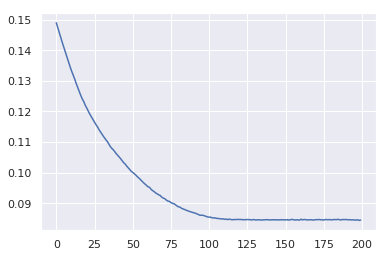

In [301]:
plt.figure()
train_losses_total = [loss['total'] for loss in train_losses_all_epochs]
plt.plot(range(N_EPOCHS), train_losses_total)

In [302]:
print('-- True values of parameters')
for name, param in decoder_true.named_parameters():
    print(name, param.data, '\n')

decoder = modules['decoder']
print('\n-- Learnt values of parameters')
for name, param in decoder.named_parameters():
    print(name, param.data, '\n')

-- True values of parameters
layers.0.weight tensor([[2.]], device='cuda:0') 


-- Learnt values of parameters
layers.0.weight tensor([[-0.1827]], device='cuda:0') 



In [303]:
n_samples = 1000
generated_true_x = generate_from_decoder(decoder_true, n_samples)
generated_x = generate_from_decoder(decoder, n_samples)

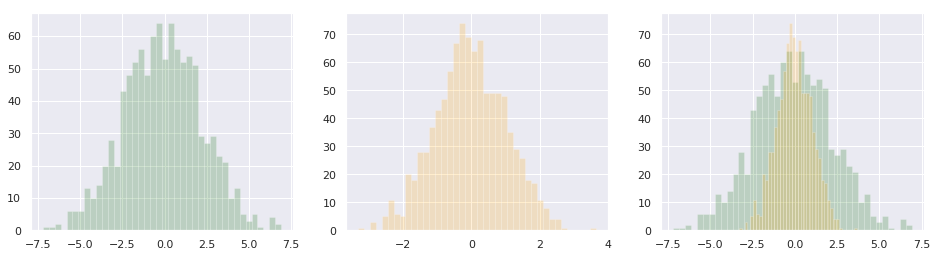

In [304]:
# For 1D
fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(16, 4))
axis_side = 20

ax = axes[0]
plot_data(generated_true_x, axis_side=axis_side, color='darkgreen', ax=ax)

ax = axes[1]
plot_data(generated_x, axis_side=axis_side, color='orange', ax=ax)

ax = axes[2]
plot_data(generated_true_x, axis_side=axis_side, color='darkgreen', ax=ax)
plot_data(generated_x, axis_side=axis_side, color='orange', ax=ax)